### Project Imports

In [43]:
import os.path
import numpy as np
import pandas as pd
import torch
import pickle
import subprocess
from matplotlib import pyplot as plt
from Bio import SeqIO
from importlib import reload
import warnings

import minimal_version.parser_handler
%cd /Users/dahala/GitHub/VAE-enzymes/vae_notebooks/
from minimal_version.preprocess_msa import Preprocessor, weight_sequences
from minimal_version.msa import MSA
from minimal_version.utils import Capturing, store_to_pkl, store_to_fasta, load_from_pkl

from minimal_version.train import setup_train, Train
%cd /Users/dahala/GitHub/VAE-enzymes/vae_notebooks/notebooks/

/Users/dahala/GitHub/VAE-enzymes/vae_notebooks
/Users/dahala/GitHub/VAE-enzymes/vae_notebooks/notebooks


### Project Configuration
Configure your project using the configuration file. Use the modelConfig template as a guide. 

A value of -1 indicates that the default value will be used. 

Please note that every time the RunSetup class is executed, the current version of the configuration file will be copied to your specified directory, allowing you to review all set parameters at any time.  

Run just one of the two cell below (working with/without Pfam)

In [2]:
#CONFIGURATION_FILE = "pfamGT1Small_filtered_hmm.json"
CONFIGURATION_FILE = "msaEnzymeMiner_PtUGT1.json"
#CONFIGURATION_FILE = "msaGASP_bigMSA.json"
run = minimal_version.parser_handler.RunSetup(CONFIGURATION_FILE)
print(f" Working with {CONFIGURATION_FILE} configuration file!")
PFAM_INPUT = False

Configuration file stored in ../results/EnzymeMiner_PtUGT1/config/2024-10-10_10-06.json
 Working with msaEnzymeMiner_PtUGT1.json configuration file!


In [183]:
sub_cids = [7257, 79964, 445154, 5315892, 5280343, 444539, 6549, 445858, 1548943, 932]
sub_idx = 1
#CONFIGURATION_FILE = f"json_files_GASPcondition/msaGASP_bigMSA_{sub_cids[sub_idx]}.json"
#CONFIGURATION_FILE = f"json_files_GASPcondition/msaEnzymeMiner_PtUGT1_{sub_cids[sub_idx]}.json"
CONFIGURATION_FILE = f"json_files_GASPcondition/msaEnzymeMiner_PtUGT1_{sub_cids[sub_idx]}_200.json"
#CONFIGURATION_FILE = f"json_files_GASPcondition/msaEnzymeMiner_PtUGT1_3dim_{sub_cids[sub_idx]}.json"
run = minimal_version.parser_handler.RunSetup(CONFIGURATION_FILE)
print(f" Working with {CONFIGURATION_FILE} configuration file!")
PFAM_INPUT = False

Configuration file stored in ../results/EnzymeMiner_PtUGT1_79964_200/config/2024-10-09_16-03.json
 Working with json_files_GASPcondition/msaEnzymeMiner_PtUGT1_79964_200.json configuration file!


In [44]:
#CONFIGURATION_FILE = f"json_files_GASPcondition/msaEnzymeMiner_PtUGT1_DCA_DCP_345.json"
CONFIGURATION_FILE = f"json_files_GASPcondition/msaEnzymeMiner_PtUGT1_DCA_DCP_200.json"
run = minimal_version.parser_handler.RunSetup(CONFIGURATION_FILE)
print(f" Working with {CONFIGURATION_FILE} configuration file!")
PFAM_INPUT = False

Configuration file stored in ../results/EnzymeMiner_PtUGT1_DCA_DCP_200/config/2024-10-10_10-28.json
 Working with json_files_GASPcondition/msaEnzymeMiner_PtUGT1_DCA_DCP_200.json configuration file!


In [ ]:
CONFIGURATION_FILE = "pfamGT1Small.json"
run = minimal_version.parser_handler.RunSetup(CONFIGURATION_FILE)
print(f" Working with {CONFIGURATION_FILE} configuration file!")
PFAM_INPUT = True

In [45]:

with open(run.pickles+ "/msa_columns.pkl", "rb") as input_file:
   msa_columns = pickle.load(input_file)
   
def fix_seqs(input_string):
    seq_ = input_string.replace('.', '')
    seq_ = ''.join([char for char in seq_ if not char.islower()])
    return seq_

def gaplimiter(seq,threshold=0.7):
    gap_percent = seq.count('-') / len(seq)
    if gap_percent > threshold:
        return False
    else:
        return True
    
def gaplimiter_df(df,threshold=0.7):
    return df[df['trimmed_afa'].apply(lambda x: gaplimiter(x,threshold))]

def apply_msa_mask(msa_df, msa_columns):
    msa_df['trimmed_afa'] = msa_df['afa'].apply(lambda x: ''.join([x[i] for i in msa_columns]))
    return msa_df

def hmmer_align(fasta_name,hmm_model,out_path,hmmer_path='/Users/dahala/Projects/HMMER/bin',fasta_ext = 'faa'):
    subprocess.run(f'{hmmer_path}/hmmalign --trim --outformat afa /Users/dahala/GitHub/VAE-enzymes/hmm_model/{hmm_model}.hmm ../datasets/{fasta_name}.{fasta_ext} > {out_path}/hmm/{fasta_name}.afa', shell=True, executable="/bin/zsh")
    return f'{out_path}/hmm/{fasta_name}.afa'

def aligned_df(afa_path,msa_columns=msa_columns):
    dict = {seq.description: fix_seqs(str(seq.seq)) for seq in SeqIO.parse(afa_path, "fasta")}
    df = pd.DataFrame.from_dict(dict, orient='index', columns=['afa'])
    df = apply_msa_mask(df, msa_columns)
    return df

def encode_custom_seqs(fasta_name,hmm_model,out_path,msa_columns=msa_columns,fasta_ext = 'faa',model= f'vae_fold_0.model',batch_size=1):
    afa_path = hmmer_align(fasta_name,hmm_model,out_path,fasta_ext = fasta_ext)
    df = aligned_df(afa_path,msa_columns)
    run.weights = f'{out_path}/model/{model}'
    latent_space = LatentSpace(run)
    mu1_ = []
    mu2_ = []
    for i in range(0, len(df), batch_size):
        latent_embeddings = latent_space.encode(df['trimmed_afa'].to_list()[i:i+batch_size])[0]
        mu1_.append(latent_embeddings[:,0])
        mu2_.append(latent_embeddings[:,1])
    df['mu1'] = np.concatenate(mu1_)
    df['mu2'] = np.concatenate(mu2_)
    return df

def encode_custom_seqs_conditional(fasta_name,hmm_model,out_path,label_list,msa_columns=msa_columns,fasta_ext = 'faa',model= f'vae_fold_0.model'):
    afa_path = hmmer_align(fasta_name,hmm_model,out_path,fasta_ext = fasta_ext)
    df = aligned_df(afa_path,msa_columns)
    run.weights = f'{out_path}/model/{model}'
    latent_space = LatentSpace(run)
    mu1_ = []
    mu2_ = []
    for i in range(0, len(df)):
        encoding = df['trimmed_afa'].to_list()[i]
        label = label_list[i]
        latent_embeddings = latent_space.encode(encoding,c=label)[0]
        mu1_.append(latent_embeddings[:,0])
        mu2_.append(latent_embeddings[:,1])
    df['mu1'] = np.concatenate(mu1_)
    df['mu2'] = np.concatenate(mu2_)
    return df

def encode_custom_seqs_conditional_3D(fasta_name,hmm_model,out_path,label_list,msa_columns=msa_columns,fasta_ext = 'faa',model= f'vae_fold_0.model'):
    afa_path = hmmer_align(fasta_name,hmm_model,out_path,fasta_ext = fasta_ext)
    df = aligned_df(afa_path,msa_columns)
    run.weights = f'{out_path}/model/{model}'
    latent_space = LatentSpace(run)
    mu1_ = []
    mu2_ = []
    mu3_ = []
    for i in range(0, len(df)):
        encoding = df['trimmed_afa'].to_list()[i]
        label = label_list[i]
        latent_embeddings = latent_space.encode(encoding,c=label)[0]
        mu1_.append(latent_embeddings[:,0])
        mu2_.append(latent_embeddings[:,1])
        mu3_.append(latent_embeddings[:,2])
    df['mu1'] = np.concatenate(mu1_)
    df['mu2'] = np.concatenate(mu2_)
    df['mu3'] = np.concatenate(mu3_)
    return df

### HMM alignment preprocessing
This preprocessing step generates a Hidden Markov Model (HMM) profile from a Multiple Sequence Alignment (MSA) and realigns the sequences from the MSA to this profile, resulting in a HMM-MSA. 

The HMM-MSA can then be utilized as a classical input MSA in the Variational Autoencoder (VAE) pipeline, offering the advantage of facilitating the alignment of different query sequences to the HMM profile. If this option is enabled, ensure that the dataset path in the configuration file is updated to the new fixed path to maintain consistency in future experiments.

Install hmmer to your system first: for example **apt install hmmer** 

In [ ]:
# If you want to use hmm aligner run this cell
hmmAligner = HMMAligner(run)
hmmAligner.buildHMM()

In [ ]:
hmmAligner.hmmer_align("yourCustomFasta")  # you can align your custom sequences to the hmm model here 

### MSA preprocessing
Prepare your MSA for training by filtering it according to the queries specified in the configuration file. This includes both the query sequences and any fixed sequences defined.

In [132]:
"""
Preprocess MSA and prepare it for VAE model training
"""

# logging
msa_log = open(os.path.join(run.logs, 'msa_log.txt'), "w")

# MSA loading
if PFAM_INPUT:
    msa = MSA.load_pfam(run.dataset)
else:
    msa = MSA.load_msa(run.dataset)
MSA.amino_acid_dict(run.pickles)
msg = f"MSA in {run.dataset} loaded\n" \
      f"number of sequences: {len(list(msa.keys()))}"
print(msg)
msa_log.write(msg + f'\n{"="*80}\n')

# MSA preprocessing
preprocessor = Preprocessor(run)
with Capturing() as output:
    msa, msa_keys = preprocessor.trim_msa(msa)
msa_log.write(" MSA Preprocessing \n" + "\n".join(output) + f'\n{"="*80}\n')
assert (msa.shape[0] == len(msa_keys))
trim_file_path = os.path.join(run.msa, "trimmed_msa.fasta")
msg = f"Trimmed MSA has {msa.shape[0]} sequences and the width is {msa.shape[1]}\n" \
      f"Trimmed MSA is stored at {trim_file_path}"
print(msg)
msa_log.write(msg + f'\n{"="*80}\n')
msa_num_dict_shuffled = {k: seq for k, seq in zip(msa_keys, msa)}  # transform to dictionary, have keys together
# but secure that query and fixed sequences are at the beginning 
msa_num_dict = {k: msa_num_dict_shuffled[k] for k in preprocessor.keep_keys}
msa_num_dict.update({k: msa_num_dict_shuffled[k] for k in msa_num_dict_shuffled if k not in preprocessor.keep_keys})

trimmed_msa = MSA.number_to_amino(msa_num_dict)
store_to_fasta(trimmed_msa, trim_file_path)
store_to_pkl({run.query: trimmed_msa[run.query]}, os.path.join(run.pickles, "reference_seq.pkl"))

# Filtering or weighting
with Capturing() as output:
    if run.clustering:  # MSA filtering
        print(f"MSA {run.identity}% identity filtering step")
        msa_num_dict = preprocessor.identity_filtering(msa_num_dict)
        msa, training_alg = preprocessor.get_keys_file_and_np_sequences(msa_num_dict)  # Overlap one treemmer
        seq_weight = np.ones(msa.shape[0])  # we just provide uniform weights for all sequences
    else:  # otherwise the weighting mechanism will be applied
        msa, training_alg = preprocessor.get_keys_file_and_np_sequences(msa_num_dict)  # Overlap one treemmer
        seq_weight = weight_sequences(msa)
msa_log.write("\n".join(output))
train_msa_file_path = os.path.join(run.msa, "training_msa.fasta")
training_alg = MSA.number_to_amino(training_alg)
store_to_fasta(training_alg, train_msa_file_path)
msg = f"Training MSA has {msa.shape[0]} sequences and the width is {msa.shape[1]}\n" \
      f"Training MSA is stored at {train_msa_file_path}"
print(msg)
msa_log.write(msg + f'\n{"=" * 80}\n')

store_to_pkl(seq_weight, os.path.join(run.pickles, "seq_weight.pkl"))
store_to_pkl(training_alg, os.path.join(run.pickles, "training_alignment.pkl"))

# MSA one-hot encoding
binary = MSA.number_to_binary(msa)
store_to_pkl(binary, os.path.join(run.pickles, "seq_msa_binary.pkl"))
msa_log.close()


MSA in ../datasets/EnzymeMiner_PtUGT1_fix.afa loaded
number of sequences: 3437
Trimmed MSA has 3416 sequences and the width is 444
Trimmed MSA is stored at ../results/EnzymeMiner_PtUGT1_7257/msa/trimmed_msa.fasta
Training MSA has 3416 sequences and the width is 444
Training MSA is stored at ../results/EnzymeMiner_PtUGT1_7257/msa/training_msa.fasta


### Conditional labels
Before starting the training process, ensure that your labels are properly preprocessed if you intend to use them for **conditional training**. 

This involves converting your labels into a suitable format, such as one-hot or integer encoding (see and modify **custom_classifier** function). 

Additionally, specify the number of classes represented by your labels.

In [46]:
# Specify number of classes
N_CLASSES = 2
head = 0
first_col = 1
#run.prob_threshold = 0.345
def parse_conditional_labels_to_categories(file_name):
    """ Parse conditional label file """
    # Please specify your classification function to the bins, the interface of function must stay the same, example
    def custom_classifier(prob_vals) -> torch.Tensor:
        label = torch.zeros(N_CLASSES)
        for i,val in enumerate(prob_vals):
            if val > run.prob_threshold:
                label[i] = 1
        return label
    
    label_dict = {}
    prob_df = pd.read_csv(file_name,delimiter='\t',header=head)
    for acc,label_vals in zip(prob_df.enzyme,prob_df.iloc[:,first_col:].values):
            if label_vals is None:
                print(f"Error while parsing labels, accession {acc} does not have labels")
                exit(1)
            label_dict[acc] = custom_classifier(label_vals)
    return label_dict

""" In the case of conditional model please preprocess labels """
label_file_path = run.conditional_labels  # you can specify it in the configuration path or provide custom one 

# Now get labels from your file, simple txt or similar file with sequence accession\tlabel_value pair per line (modify function as needed)  
label_dict = parse_conditional_labels_to_categories(label_file_path)

labels_file_pkl = os.path.join(run.conditional_data, "conditional_labels_to_categories.pkl")
msa_keys = load_from_pkl(os.path.join(run.pickles, "keys_list.pkl"))

# get labels to the similar order as in msa (just in case, to enable using indexes in training method)
msa_key_label_order = {}
array_of_labels = torch.zeros(len(msa_keys), N_CLASSES)
for label_i, msa_key in enumerate(msa_keys):
    try:
        msa_key_fix = msa_key.split()[0]
        msa_key_label_order[msa_key] = label_dict[msa_key_fix]
        array_of_labels[label_i] = label_dict[msa_key_fix]
    except KeyError:
        print(f"{msa_key} is not in the label_dict, please provide labels for all sequences")
        exit(1)
        
# now store in both raw and text version
store_to_pkl(array_of_labels, labels_file_pkl)
with open(os.path.join(run.conditional_data, "msa_key_label_order.txt"), 'w') as txt_labels:
    for k, label_tensor in msa_key_label_order.items():
        txt_labels.write(f"{k} {label_tensor}\n")

### Training of the model
Select the models you would like to work with and prepare data for training and benchmarking if selected in configuration file. 

If you select a conditional model please see above cell and prepare labels for it.  

In [ ]:
""" Configure model """
available_models = ["vae", "vae_conditional"]
model_selected = available_models[1]

""" Prepare data for training """
setup_train(run, model_selected)
model = Train(run)

In [ ]:
"""
Train VAE with a preprocessed MSA
:param conf_path: path to the configuration file of the project
:return:
"""
# logging
train_log = open(os.path.join(run.logs, 'train_log.txt'), "w")
model = Train(run)
with Capturing() as output_train:
    model.train()
train_log.write(" Training \n" + "\n".join(output_train) + f'\n{"=" * 80}\n')
train_log.close()

In [8]:
""" Do I work with conditional model? """

load_from_pkl(os.path.join(run.model, "model_params.pkl"))['model']

'vae'

### Generative Capacity evaluation
If you wish to obtain estimates of your model's generative capacity, please set run_capacity_test to true in the configuration file before starting the training.

This test generates first and second order statistics of your model.

In [ ]:
%cd /Users/dahala/GitHub/VAE-enzymes/vae_notebooks
from notebooks.minimal_version.benchmark import Benchmarker
%cd /Users/dahala/GitHub/VAE-enzymes/vae_notebooks/notebooks/
run.weights = f'{run.results[:-7]}model/vae_fold_0_e3999.model'
""" 
Benchmark model 
How well our model can regenarate sequences in various sets (positive, negative and training)
"""
N_SAMPLES = 500

Benchmarker(run, samples=N_SAMPLES).bench_dataset()


### Projection to the latent space
Project all points to the latent space and make custom selection of sequences

In [ ]:
%cd /Users/dahala/GitHub/VAE-enzymes/vae_notebooks
from matplotlib import pyplot as plt
from notebooks.minimal_version.latent_space import LatentSpace
%cd /Users/dahala/GitHub/VAE-enzymes/vae_notebooks/notebooks/
for epoch in range(1,15000):
    if (epoch + 1) % 500 == 0:
        # Projection to the latent space
        # Show your queries
        run.weights = f'{run.results[:-7]}model/vae_fold_0_e{epoch}.model'
        latent_space = LatentSpace(run)
        msa_embeddings = latent_space.msa_embeddings["mus"]


        query_coords = latent_space.key_to_embedding(run.fixed_sequences)

        custom_sequences = []  # give keys to MSA and embed them to the latent space


        fig_lat, ax = plt.subplots(1, 1)

        ax.plot(msa_embeddings[:, 0], msa_embeddings[:, 1], '.', alpha=0.1, markersize=3, )
        ax.plot(query_coords[0::2], query_coords[1::2], '.', color='red')

        # Project 
        for seq_id, seq_mu in enumerate(custom_sequences):
            ax.plot(seq_mu[0], seq_mu[1], '.', color='black', alpha=1, markersize=5,
                    label='({})'.format(seq_id))
            
            ax.annotate(str(seq_id), (seq_mu[0], seq_mu[1]))
        ax.set_xlabel("$Z_1$")
        ax.set_ylabel("$Z_2$")
        ax.set_title(f"Latent space projection epoch {epoch}")
        fig_lat.savefig(os.path.join(run.results, f"latent_space_e{epoch}.png"))

/Users/dahala/GitHub/VAE-enzymes/vae_notebooks
/Users/dahala/GitHub/VAE-enzymes/vae_notebooks/notebooks


/Users/dahala/GitHub/VAE-enzymes/vae_notebooks/notebooks/minimal_version/latent_space.py:42: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  vae.load_state_dict(torch.load(sel

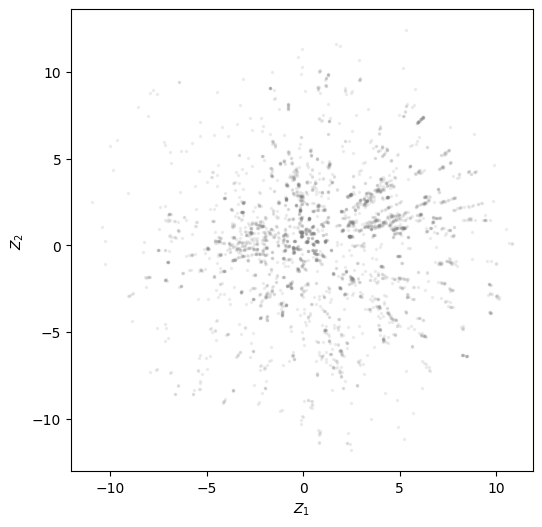

In [54]:
%cd /Users/dahala/GitHub/VAE-enzymes/vae_notebooks
from matplotlib import pyplot as plt
from notebooks.minimal_version.latent_space import LatentSpace
%cd /Users/dahala/GitHub/VAE-enzymes/vae_notebooks/notebooks/

# Projection to the latent space
# Show your queries
run.weights = f'{run.result}/model/vae_fold_0.model'
latent_space = LatentSpace(run)
msa_embeddings = latent_space.msa_embeddings["mus"]


query_coords = latent_space.key_to_embedding(run.fixed_sequences)

custom_sequences = []  # give keys to MSA and embed them to the latent space
c_color = 'blue'
conditional = False
fig_lat, ax = plt.subplots(1, 1,figsize=(6,6))
if conditional:
    for i,label in enumerate(msa_key_label_order.values()):
        if label[0] == 1:
        #if label[0] == 1:
            ax.plot(msa_embeddings[i, 0], msa_embeddings[i, 1], '.', alpha=0.5, markersize=3, color=c_color)
        else:
            ax.plot(msa_embeddings[i, 0], msa_embeddings[i, 1], '.', alpha=0.1, markersize=3, color='gray')
    ax.plot(query_coords[0::2], query_coords[1::2], '.', color='k')
else:
    ax.plot(msa_embeddings[:, 0], msa_embeddings[:, 1], '.', alpha=0.1, markersize=3, color='grey')
    #ax.plot(query_coords[0::2], query_coords[1::2], '.', color='red')

# Project 
ax.set_box_aspect(1)
ax.set_xlabel("$Z_1$")
ax.set_ylabel("$Z_2$")
ax.set_box_aspect(1)
if conditional:
    fig_lat.savefig(os.path.join(run.results, f"latent_space_conditional.png"))
else:
    fig_lat.savefig(os.path.join(run.results, f"latent_space.png"))
    #ax.set_title(f"Latent space projection final")

#### Multi Label

In [47]:
color_dict = {'[1.0, 0.0]':'red','[0.0, 1.0]':'blue','[1.0, 1.0]':'gold','[0.0, 0.0]':'grey'}
alpha_dict = {'[0.0, 1.0]':0.5,'[1.0, 0.0]':0.5,'[1.0, 1.0]':0.5,'[0.0, 0.0]':0.1}

/Users/dahala/GitHub/VAE-enzymes/vae_notebooks
/Users/dahala/GitHub/VAE-enzymes/vae_notebooks/notebooks


/Users/dahala/GitHub/VAE-enzymes/vae_notebooks/notebooks/minimal_version/latent_space.py:42: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  vae.load_state_dict(torch.load(sel

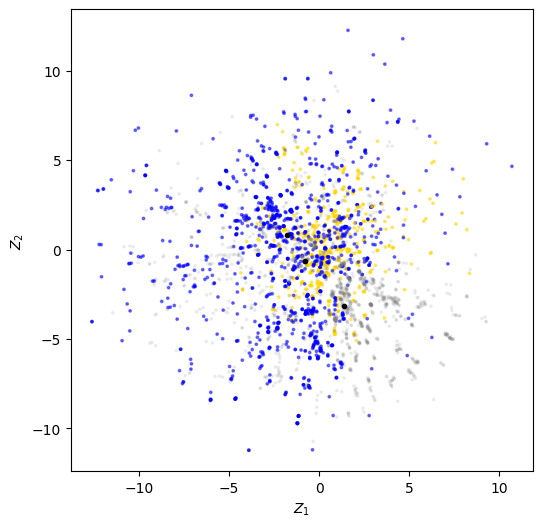

In [48]:
%cd /Users/dahala/GitHub/VAE-enzymes/vae_notebooks
from matplotlib import pyplot as plt
from notebooks.minimal_version.latent_space import LatentSpace
%cd /Users/dahala/GitHub/VAE-enzymes/vae_notebooks/notebooks/

# Projection to the latent space
# Show your queries
run.weights = f'{run.result}/model/vae_fold_0.model'
latent_space = LatentSpace(run)
msa_embeddings = latent_space.msa_embeddings["mus"]

query_coords = latent_space.key_to_embedding(run.fixed_sequences)

fig_lat, ax = plt.subplots(1, 1,figsize=(6,6))



color_msa = []
alpha_msa = []
for i,label in enumerate(msa_key_label_order.values()):
    color_msa.append(color_dict[str(label.tolist())])
    alpha_msa.append(alpha_dict[str(label.tolist())])
ax.scatter(msa_embeddings[:, 0], msa_embeddings[:, 1], c=color_msa, alpha=alpha_msa, s=3, zorder=3)
ax.plot(query_coords[0::2], query_coords[1::2], '.', color='black',zorder=5)
ax.set_box_aspect(1)
ax.set_xlabel("$Z_1$")
ax.set_ylabel("$Z_2$")
#ax.set_title(f"Latent space projection final")
fig_lat.savefig(os.path.join(run.results, f"latent_space_conditional.png"))


### 3D Projection to the latent space
Project all points to the latent space and make custom selection of sequences

/Users/dahala/GitHub/VAE-enzymes/vae_notebooks
/Users/dahala/GitHub/VAE-enzymes/vae_notebooks/notebooks


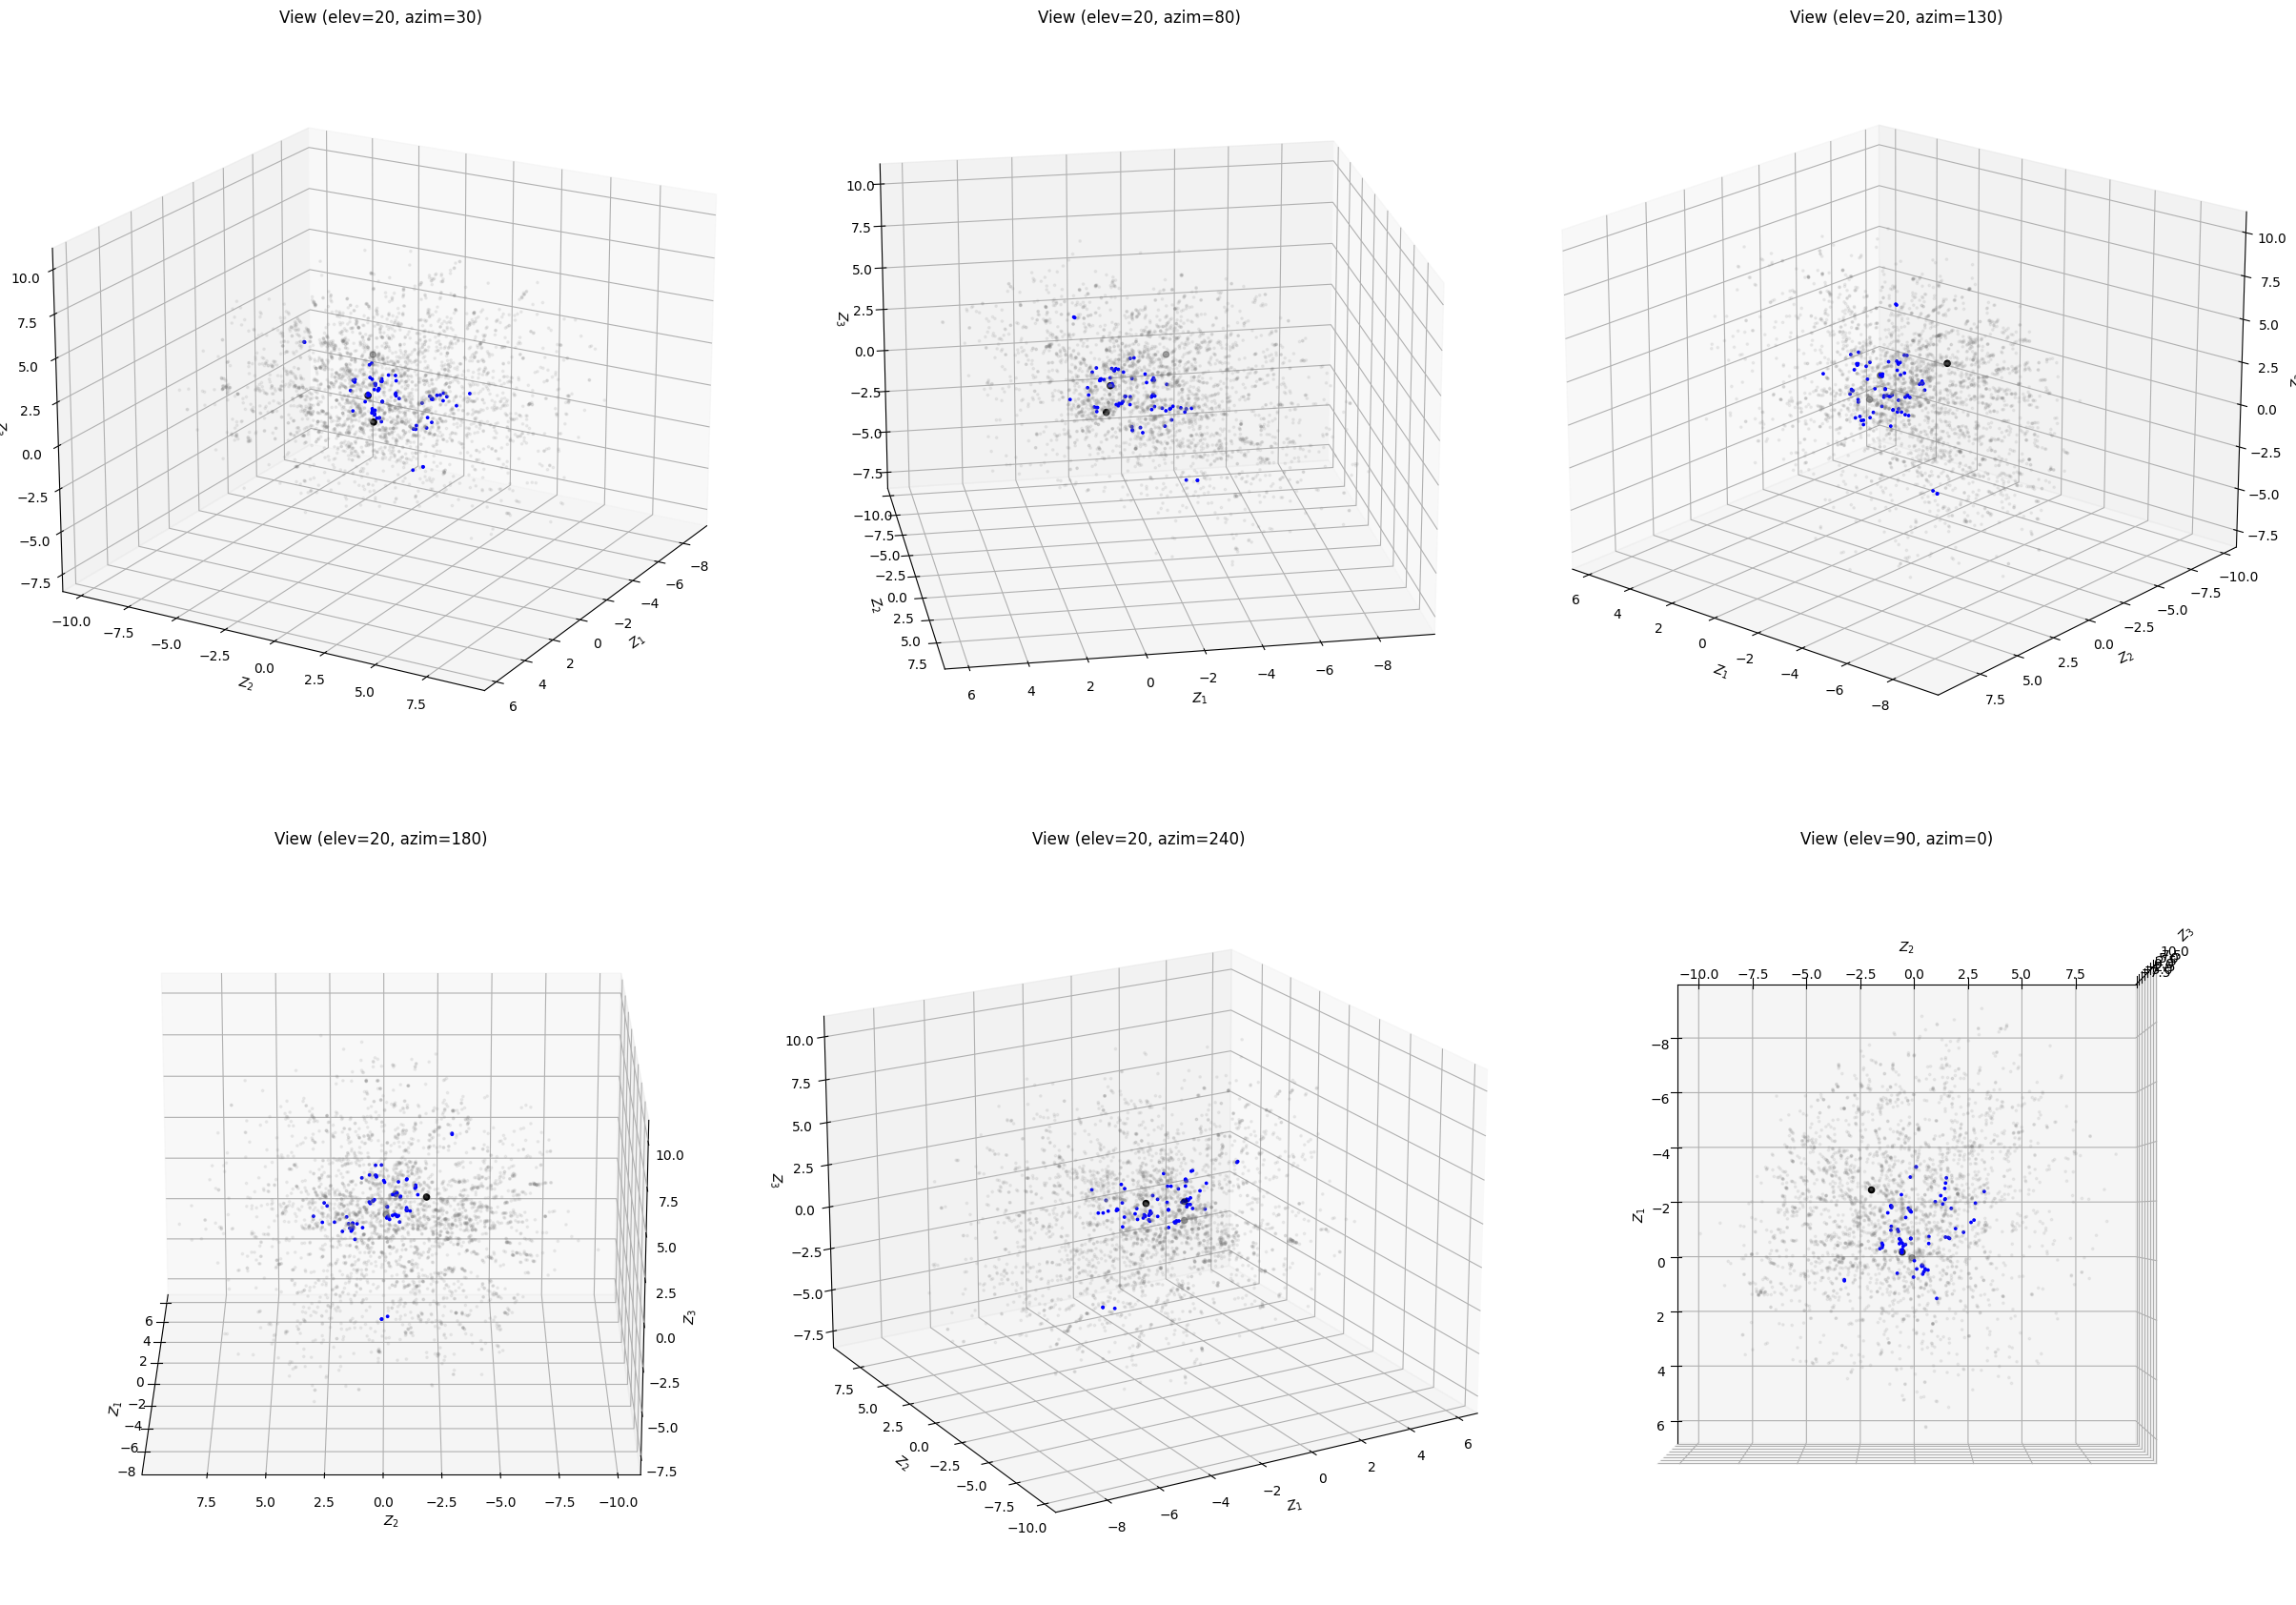

In [184]:
%cd /Users/dahala/GitHub/VAE-enzymes/vae_notebooks
from matplotlib import pyplot as plt
from notebooks.minimal_version.latent_space import LatentSpace
%cd /Users/dahala/GitHub/VAE-enzymes/vae_notebooks/notebooks/

# Projection to the latent space
# Show your queries
#run.weights = f'{run.result}/model/vae_fold_0_e9999.model'
latent_space = LatentSpace(run)
msa_embeddings = latent_space.msa_embeddings["mus"]


query_coords = latent_space.key_to_embedding(run.fixed_sequences)


conditional = True
# Prepare arrays to store points for each label
red_points = []
blue_points = []

if conditional:
    for i, label in enumerate(msa_key_label_order.values()):
        if label[0] == 1:
        #if label[0] == 1:
            red_points.append(msa_embeddings[i].numpy())
        else:
            blue_points.append(msa_embeddings[i].numpy())

# Convert to NumPy arrays for easier handling
red_points = np.array(red_points)
blue_points = np.array(blue_points)

angles = [(20, 30), (20, 80), (20, 130), (20, 180), (20, 240), (90, 0)]

# Create a figure with 4 subplots for different angles
fig = plt.figure(figsize=(24, 18))

for idx, (elev, azim) in enumerate(angles):
    ax = fig.add_subplot(2, 3, idx + 1, projection='3d')

    # Plot all red points in one scatter call
    if red_points.size > 0:
        ax.scatter(red_points[:, 0], red_points[:, 1], red_points[:, 2], alpha=1, s=3, color='blue')

    # Plot all blue points in one scatter call
    if blue_points.size > 0:
        ax.scatter(blue_points[:, 0], blue_points[:, 1], blue_points[:, 2], alpha=0.1, s=3, color='grey')

    # Plot query coordinates
    ax.scatter(query_coords[0::3], query_coords[1::3], query_coords[2::3], color='k', s=20)

    # Set labels and title for each subplot
    ax.set_xlabel("$Z_1$")
    ax.set_ylabel("$Z_2$")
    ax.set_zlabel("$Z_3$")
    ax.set_title(f"View (elev={elev}, azim={azim})")
    
    # Set the view angle
    ax.view_init(elev=elev, azim=azim)

# Adjust layout
plt.tight_layout()
plt.savefig(os.path.join(run.results, f"latent_space_3d.png"))
plt.show()

### Generate ancestors
Using straight evolution protocol  

In [ ]:
from notebooks.minimal_version.evolution_protocols.straight_evolution import StraightEvolution
#run.weights = f'../results/EnzymeMiner_PtUGT1/model/vae_fold_0_e3999.model'
latent_space = LatentSpace(run)
msa_embeddings = latent_space.msa_embeddings["mus"]
protocol = StraightEvolution(run)
ancestors = protocol.get_ancestors(profile=False)  # FIXME

In [10]:
import sys, importlib
importlib.reload(sys.modules['notebooks.minimal_version.latent_space'])
from notebooks.minimal_version.latent_space import LatentSpace

In [11]:
fireprot_ancestors = {}
for i in range(151,300):
    seq = np.loadtxt(f'../../FireProtASR_results/ancestrals/node_{i}.fas',dtype=str)
    seq = str(seq)
    fireprot_ancestors[f'anc{i}'] = seq

In [ ]:
hmm_name = 'PFAM201'#'GASP'#'EnzymeMiner_PtUGT1'
fireprot_ancestors_df = encode_custom_seqs('At71B1_ancestral_sequences',hmm_name,run.root_dir,fasta_ext='fasta')#,model= f'vae_fold_0_e6499.model',batch_size=1)

In [ ]:
fireprot_ancestors_df

In [14]:
query_ancestors_df = fireprot_ancestors_df.loc[['anc_294','anc_293','anc_292','anc_289','anc_288','anc_209','anc_200','anc_196','anc_151']]

In [ ]:
run.fixed_sequences

In [ ]:
fig_lat, ax = plt.subplots(1, 1)

ax.plot(msa_embeddings[:, 0], msa_embeddings[:, 1], '.', alpha=0.1, markersize=3, color='lightgray')


# Project 
i = 0
for seq_id, seq in ancestors.items():
    seq = ''.join(seq)
    seq_mu = latent_space.encode(seq)[0][0]
    if i == 0:
        ax.plot(seq_mu[0], seq_mu[1], '.', color='red', alpha=0.2, markersize=5,
            label='VAE ancestors')
        i += 1
    else:
        ax.plot(seq_mu[0], seq_mu[1], '.', color='red', alpha=0.2, markersize=5)

i = 0
for mu1,mu2 in query_ancestors_df[['mu1','mu2']].values:
    if i == 0:
        ax.plot(mu1, mu2, '.', color='blue', alpha=0.2, markersize=5,
            label='FireProt ancestors')
        i += 1
    else:
        ax.plot(mu1, mu2, '.', color='blue', alpha=0.2, markersize=5)

ax.scatter(query_coords[0], query_coords[1], color='white',edgecolor='k', s=50, label='Query', zorder=10)
ax.legend()
ax.set_xlabel("$Z_1$")
ax.set_ylabel("$Z_2$")
fig_lat.savefig(os.path.join(run.results, "latent_space_with_anc.png"))

### Sequence Projection
Projecting custom sequence to latent space

In [8]:
latent_space = LatentSpace(run)
#hmm_name = 'PFAM201'
#hmm_name = 'GASP'
hmm_name = 'EnzymeMiner_PtUGT1'


In [8]:
known_df_ = encode_custom_seqs('KnownGT1',hmm_name,run.result,fasta_ext='faa',model= f'vae_fold_0.model',batch_size=1)
KnownUGT_df = pd.read_excel('../../UGT_names_excel.xlsx',index_col=2)
KnownUGT_df = KnownUGT_df.merge(known_df_, left_index=True, right_index=True)

/Users/dahala/GitHub/VAE-enzymes/vae_notebooks/notebooks/minimal_version/latent_space.py:42: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  vae.load_state_dict(torch.load(sel

In [9]:
All_data_df = pd.read_csv('../../All_data.csv')
Dataset1 = All_data_df[All_data_df.ID=='Dataset1']

In [10]:
All_data_unique = All_data_df.drop_duplicates(subset='Accession', keep='first')
with open('../datasets/All_data_unique.fasta', 'w') as f:
    for index, row in All_data_unique.iterrows():
        if not row['Official_name'].count('+') == 1:
            f.write(f">{row['Official_name']}\n{row['Sequence']}\n")
all_encode = encode_custom_seqs('All_data_unique',hmm_name,run.result,fasta_ext='fasta',model= f'vae_fold_0.model',batch_size=1)
All_data_unique = All_data_unique.merge(all_encode, left_on='Official_name', right_index=True)

/Users/dahala/GitHub/VAE-enzymes/vae_notebooks/notebooks/minimal_version/latent_space.py:42: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  vae.load_state_dict(torch.load(sel

In [61]:
Dataset1 = All_data_df[All_data_df.ID=='Dataset1']
with open('../datasets/Dataset1.faa','w') as f:
    for enz,seq in zip(Dataset1['Official_name'],Dataset1['Sequence']):
        f.write(f'>{enz}\n{seq}\n')
dataset1_encode = encode_custom_seqs('Dataset1',hmm_name,run.result,fasta_ext='faa',model= f'vae_fold_0.model',batch_size=1)
Dataset1 = Dataset1.merge(dataset1_encode, left_on='Official_name', right_index=True)
Dataset1_test = Dataset1[Dataset1.Acceptor.isin(['3,4-Dichloroaniline', '3,4-Dichlorothiophenol', 'Resveratrol',
                                                  'Cinnamyl alcohol', 'Quercetin', 'Cinnamic acid', 'Linalool',
                                                    'Ferulic acid', 'Capsaicin', 'Naringenin'])]

/Users/dahala/GitHub/VAE-enzymes/vae_notebooks/notebooks/minimal_version/latent_space.py:42: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  vae.load_state_dict(torch.load(sel

In [10]:
Dataset1_Dichloroaniline_bin = Dataset1[(Dataset1.Acceptor=='3,4-Dichloroaniline')&(Dataset1.Measurement_type=='Activity_score')]
with open('../datasets/Dataset1_Dichloroaniline.faa','w') as f:
    for enz,seq in zip(Dataset1_Dichloroaniline_bin['Official_name'],Dataset1_Dichloroaniline_bin['Sequence']):
        f.write(f'>{enz}\n{seq}\n')
Dataset1_Dichloroaniline_labels = torch.zeros(24,1)
Dataset1_Dichloroaniline_labels_neg = torch.zeros(24,1)
for i, val in enumerate(Dataset1_Dichloroaniline_bin['Measurement_val']):
    Dataset1_Dichloroaniline_labels[i,0] = 1 if float(val) == 1 else 0
    Dataset1_Dichloroaniline_labels_neg[i,0] = 1 if float(val) == 0 else 0
dataset1_bin_encode = encode_custom_seqs('Dataset1_Dichloroaniline',hmm_name,run.result,fasta_ext='faa',model= f'vae_fold_0.model')
Dataset1_Dichloroaniline_bin = Dataset1_Dichloroaniline_bin.merge(dataset1_bin_encode, left_on='Official_name', right_index=True)
dataset1_bin_encode_neg = encode_custom_seqs('Dataset1_Dichloroaniline',hmm_name,run.result,fasta_ext='faa',model= f'vae_fold_0.model')
Dataset1_Dichloroaniline_bin = Dataset1_Dichloroaniline_bin.merge(dataset1_bin_encode_neg[['mu1','mu2']], left_on='Official_name', right_index=True,suffixes=('','_neg'))

/Users/dahala/GitHub/VAE-enzymes/vae_notebooks/notebooks/minimal_version/latent_space.py:42: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  vae.load_state_dict(torch.load(sel

In [11]:
Dataset1_DCP_bin = Dataset1[(Dataset1.Acceptor=='3,4-Dichlorothiophenol')&(Dataset1.Measurement_type=='Activity_score')]
with open('../datasets/Dataset1_DCP.faa','w') as f:
    for enz,seq in zip(Dataset1_DCP_bin['Official_name'],Dataset1_DCP_bin['Sequence']):
        f.write(f'>{enz}\n{seq}\n')
Dataset1_DCP_labels = torch.zeros(18,1)
Dataset1_DCP_labels_neg = torch.zeros(18,1)
for i, val in enumerate(Dataset1_DCP_bin['Measurement_val']):
    Dataset1_DCP_labels[i,0] = 1 if float(val) == 1 else 0
    Dataset1_DCP_labels_neg[i,0] = 1 if float(val) == 0 else 0

dataset1_bin_encode = encode_custom_seqs('Dataset1_DCP',hmm_name,run.result,fasta_ext='faa',model= f'vae_fold_0.model')
Dataset1_DCP_bin = Dataset1_DCP_bin.merge(dataset1_bin_encode, left_on='Official_name', right_index=True)
dataset1_bin_encode_neg = encode_custom_seqs('Dataset1_DCP',hmm_name,run.result,fasta_ext='faa',model= f'vae_fold_0.model')
Dataset1_DCP_bin = Dataset1_DCP_bin.merge(dataset1_bin_encode_neg[['mu1','mu2']], left_on='Official_name', right_index=True,suffixes=('','_neg'))


/Users/dahala/GitHub/VAE-enzymes/vae_notebooks/notebooks/minimal_version/latent_space.py:42: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  vae.load_state_dict(torch.load(sel

In [12]:
cols1 = ['Official_name', 'Sequence', 'Acceptor', 'Measurement_val']
cols2 = ['Official_name', 'Acceptor', 'Measurement_val']
Dataset1_DCA_ = Dataset1[(Dataset1.Acceptor.isin(['3,4-Dichloroaniline']))&(Dataset1.Measurement_type=='Activity_score')]
Dataset1_DCP_ = Dataset1[(Dataset1.Acceptor.isin(['3,4-Dichlorothiophenol']))&(Dataset1.Measurement_type=='Activity_score')]
Dataset1_DCA_DCP_bin = pd.merge(Dataset1_DCA_[cols1],Dataset1_DCP_[cols2],on='Official_name',suffixes=('_DCA','_DCP'))
with open('../datasets/Dataset1_DCA_DCP.faa','w') as f:
    for enz,seq in zip(Dataset1_DCA_DCP_bin['Official_name'],Dataset1_DCA_DCP_bin['Sequence']):
        f.write(f'>{enz}\n{seq}\n')

In [13]:
Dataset1_DCA_DCP_labels = torch.zeros(18,2)
for i, (val1,val2) in enumerate(zip(Dataset1_DCA_DCP_bin['Measurement_val_DCA'],Dataset1_DCA_DCP_bin['Measurement_val_DCP'])):
    Dataset1_DCA_DCP_labels[i,0] = 1 if float(val1) == 1 else 0
    Dataset1_DCA_DCP_labels[i,1] = 1 if float(val2) == 1 else 0
Dataset1_DCA_DCP_bin['labels'] = Dataset1_DCA_DCP_labels.tolist()

In [14]:
encode_ = encode_custom_seqs('Dataset1_DCA_DCP',hmm_name,run.result,fasta_ext='faa',model= f'vae_fold_0.model')
Dataset1_DCA_DCP_bin = Dataset1_DCA_DCP_bin.merge(encode_, left_on='Official_name', right_index=True)

/Users/dahala/GitHub/VAE-enzymes/vae_notebooks/notebooks/minimal_version/latent_space.py:42: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  vae.load_state_dict(torch.load(sel

In [15]:
DON_GT1_kin = All_data_df[All_data_df.ID=='DON_GT1_kin']
DON_GT1_kin_unique = DON_GT1_kin.drop_duplicates(subset='Official_name')
with open('../datasets/DON_GT1_kin.faa','w') as f:
    for enz,seq in zip(DON_GT1_kin_unique.Official_name,DON_GT1_kin_unique.Sequence):
        f.write(f'>{enz}\n{seq}\n')
don_gt1_kin_df = encode_custom_seqs('DON_GT1_kin',hmm_name,run.result,fasta_ext='faa',model= f'vae_fold_0.model',batch_size=1)
DON_GT1_kin_unique = DON_GT1_kin_unique.merge(don_gt1_kin_df, left_on='Official_name', right_index=True)

/Users/dahala/GitHub/VAE-enzymes/vae_notebooks/notebooks/minimal_version/latent_space.py:42: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  vae.load_state_dict(torch.load(sel

In [18]:
PtUGT1_TMmut = All_data_df[(All_data_df.ID == 'PtUGT1_TMmut')&(All_data_df.Measurement_type=='Tm')]

with open('../datasets/PtUGT1_TMmut.faa', 'w') as f:
    for enz,mut, seq in zip(PtUGT1_TMmut['Official_name'],PtUGT1_TMmut['Mutation_position'], PtUGT1_TMmut['Sequence']):
        f.write(f'>{enz} | {mut}\n{seq}\n')

PtUGT1_TMmut_encode = encode_custom_seqs('PtUGT1_TMmut',hmm_name,run.result,fasta_ext='faa',model= f'vae_fold_0.model',batch_size=1)
for col in PtUGT1_TMmut_encode.columns:
    PtUGT1_TMmut[col] = PtUGT1_TMmut_encode[col].values

/Users/dahala/GitHub/VAE-enzymes/vae_notebooks/notebooks/minimal_version/latent_space.py:42: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  vae.load_state_dict(torch.load(sel

In [19]:
CGT_sol = All_data_df[All_data_df.ID=='CGT_sol']
with open('../datasets/CGT_sol.faa','w') as f:
    for enz,seq in zip(CGT_sol['Official_name'],CGT_sol['Sequence']):
        f.write(f'>{enz}\n{seq}\n')
cgt_sol_df = encode_custom_seqs('CGT_sol',hmm_name,run.result,fasta_ext='faa',model= f'vae_fold_0.model',batch_size=1)
CGT_sol = CGT_sol.merge(cgt_sol_df, left_on='Official_name', right_index=True)

/Users/dahala/GitHub/VAE-enzymes/vae_notebooks/notebooks/minimal_version/latent_space.py:42: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  vae.load_state_dict(torch.load(sel

In [20]:
Anthranilates_GT1 = All_data_df[(All_data_df.ID == 'Anthranilates_GT1')]
with open('../datasets/Anthranilates_GT1.faa', 'w') as f:
    for enz, seq in zip(Anthranilates_GT1['Official_name'], Anthranilates_GT1['Sequence']):
        if enz != 'Sl_UGT72B68+GmSuSy':
            f.write(f'>{enz}\n{seq}\n')
anthranilates_gt1_encode = encode_custom_seqs('Anthranilates_GT1',hmm_name,run.result,fasta_ext='faa',model= f'vae_fold_0.model',batch_size=1)
Anthranilates_GT1 = Anthranilates_GT1.merge(anthranilates_gt1_encode, left_on='Official_name', right_index=True)

/Users/dahala/GitHub/VAE-enzymes/vae_notebooks/notebooks/minimal_version/latent_space.py:42: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  vae.load_state_dict(torch.load(sel

In [21]:
KnownGT_colors = {}
okabe_ito_colors_ext = ['white','lightgray','#000000','#750000','#56B4E9','#E69F00','#009E73','#D55E00','#0072B2','#CC79A7','#F0E442','darkgray']
colors=okabe_ito_colors_ext[3:]+['darkgreen']+['#FF6865']
for i,phylum in enumerate(pd.unique(KnownUGT_df.Phylum)):
    KnownGT_colors[phylum] = colors[i]

fig_lat, ax = plt.subplots(1, 1)

ax.plot(msa_embeddings[:, 0], msa_embeddings[:, 1], '.', alpha=0.1, markersize=3, zorder=1,color='darkgray')


Project
for mu1,mu2 in query_df[['mu1','mu2']].values:
    ax.scatter(mu1, mu2, color='lightblue', alpha=1, s=100, zorder=2,edgecolor='black')

#ax.scatter(seq_mu[0], seq_mu[1], color='green', alpha=1, s=100,edgecolor='black', zorder=2)
    
    #ax.annotate(str(seq_id), (seq_mu[0], seq_mu[1]))
ax.scatter(query_coords[0::2], query_coords[1::2], color='gold', alpha=1, s=20,edgecolor='black', zorder=5)
ax.set_xlabel("$Z_1$")
ax.set_ylabel("$Z_2$")
ax.legend(fontsize=10)
fig_lat.savefig(os.path.join(run.results, "latent_space_with_custom_seq.png"))

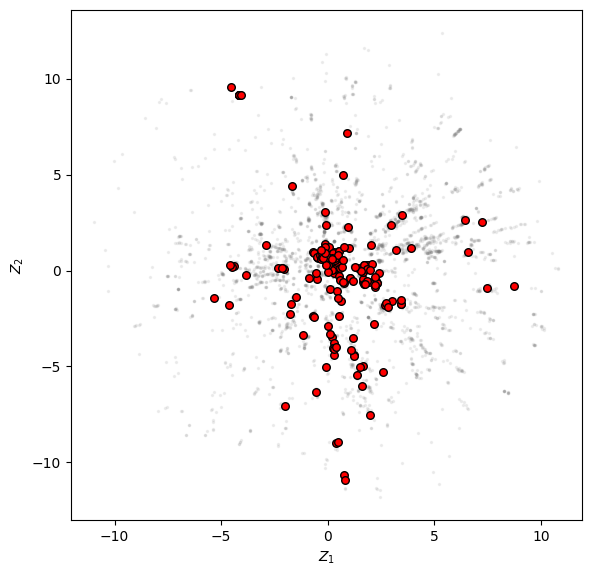

In [22]:
fig_lat, ax = plt.subplots(figsize=(6,6))
# Project
msa_embeddings = latent_space.msa_embeddings["mus"]
ax.scatter(All_data_unique.mu1, All_data_unique.mu2, color='red', alpha=1, s=30,edgecolor='black', zorder=3)
ax.set_xlabel("$Z_1$")
ax.set_ylabel("$Z_2$")

ax.plot(msa_embeddings[:, 0], msa_embeddings[:, 1], '.', alpha=0.1, markersize=3, zorder=1,color='grey')
#ax.set_xlim(-10,5)
#ax.set_ylim(-5,11)
ax.set_box_aspect(1)
plt.tight_layout()
fig_lat.savefig(os.path.join(run.results, "latent_space_with_exp_enz.png"))

In [23]:
run.results

'../results/EnzymeMiner_PtUGT1/results'

In [24]:
for sub in ['3,4-Dichloroaniline', '3,4-Dichlorothiophenol', 'Resveratrol',
                                                  'Cinnamyl alcohol', 'Quercetin', 'Cinnamic acid', 'Linalool',
                                                    'Ferulic acid', 'Capsaicin', 'Naringenin']:
    print(All_data_df[All_data_df.Acceptor==sub].Acceptor.unique(),All_data_df[All_data_df.Acceptor==sub].Acceptor_cid.unique())

['3,4-Dichloroaniline'] [7257.]
['3,4-Dichlorothiophenol'] [79964.]
['Resveratrol'] [445154.]
['Cinnamyl alcohol'] [5315892.]
['Quercetin'] [5280343.]
['Cinnamic acid'] [444539.]
['Linalool'] [6549.]
['Ferulic acid'] [445858.]
['Capsaicin'] [1548943.]
['Naringenin'] [932.]


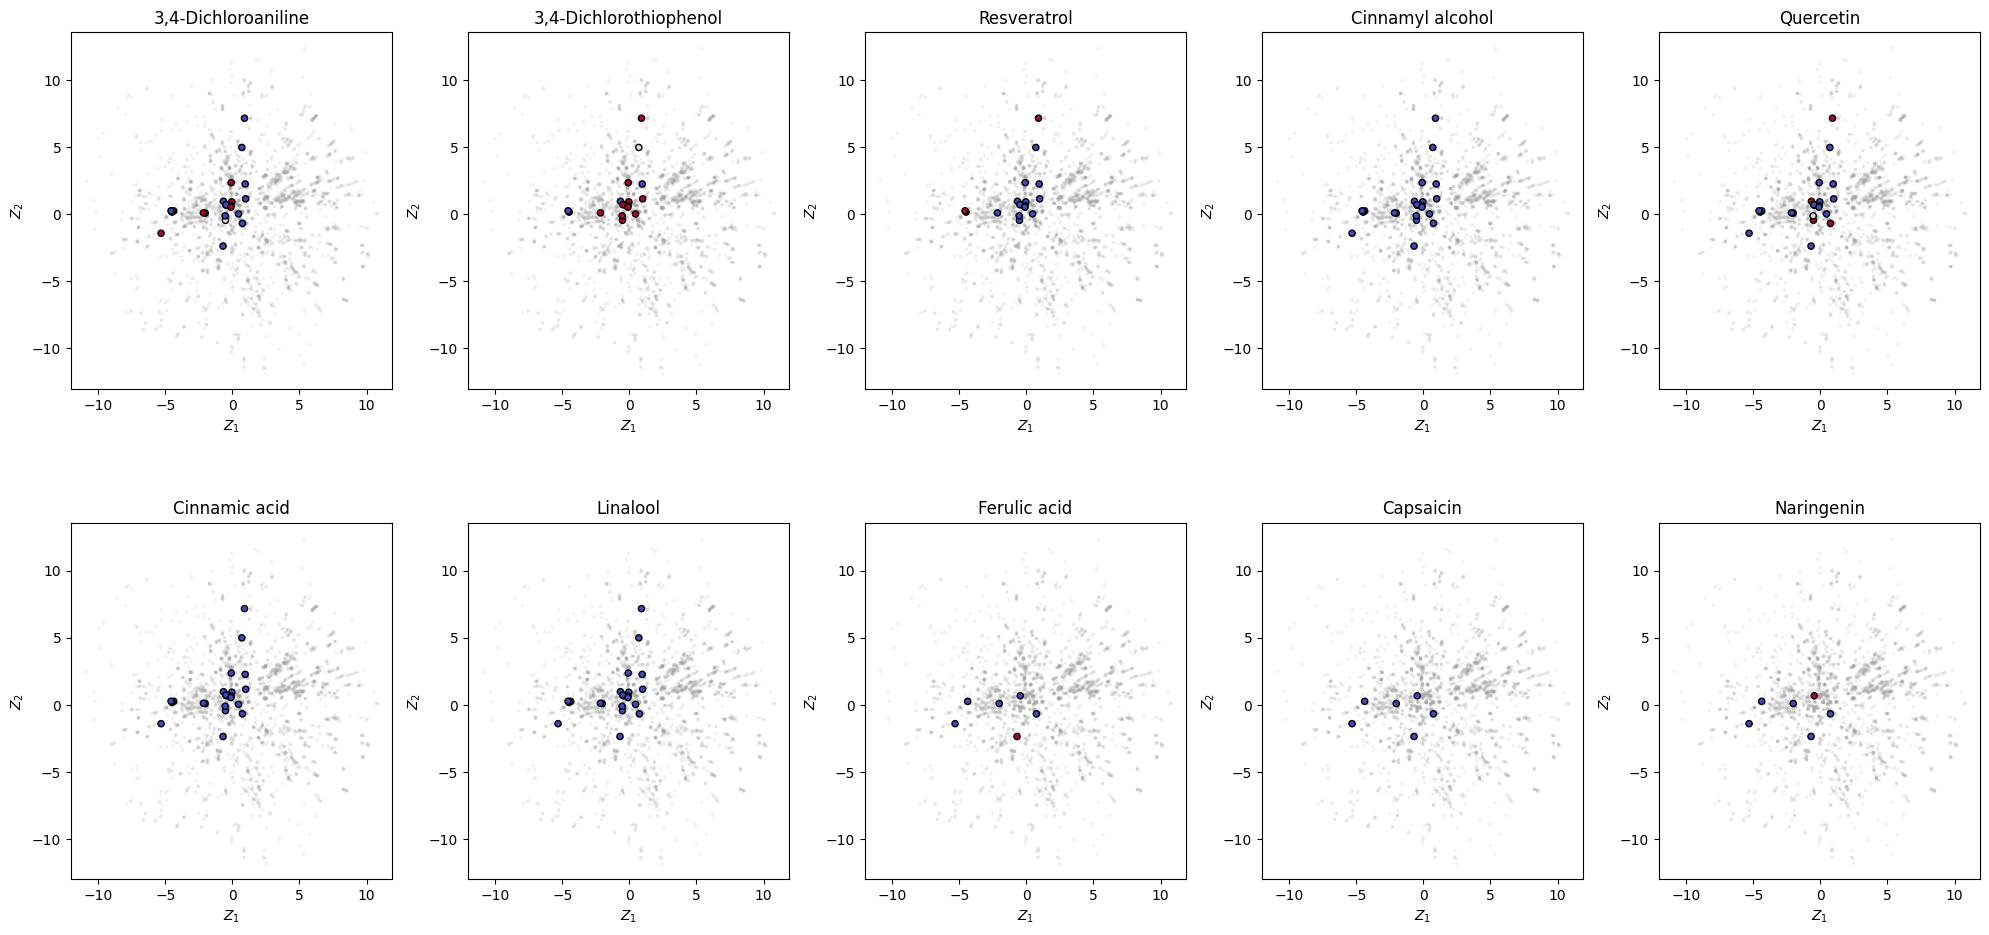

In [25]:
fig_lat, axes = plt.subplots(2, 5,figsize=(20,10))
Dataset1_test_bin = Dataset1_test[Dataset1_test.Measurement_type=='Activity_score']
# Project
for ax,substrate in zip(axes.flatten(),['3,4-Dichloroaniline', '3,4-Dichlorothiophenol', 'Resveratrol',
                                                  'Cinnamyl alcohol', 'Quercetin', 'Cinnamic acid', 'Linalool',
                                                    'Ferulic acid', 'Capsaicin', 'Naringenin']):
    subset_ = Dataset1_test_bin[(Dataset1_test_bin.Acceptor==substrate)]
    ax.scatter(subset_.mu1, subset_.mu2, c=subset_.Measurement_val.to_numpy(dtype=float), alpha=1, s=20,edgecolor='black', zorder=3,cmap='coolwarm')
    ax.set_title(substrate)
    ax.set_xlabel("$Z_1$")
    ax.set_ylabel("$Z_2$")
    ax.set_aspect('equal')
    ax.plot(msa_embeddings[:, 0], msa_embeddings[:, 1], '.', alpha=0.1, markersize=3, zorder=1,color='darkgray')
plt.tight_layout()
fig_lat.savefig(os.path.join(run.results, "latent_space_with_dataset1.png"))


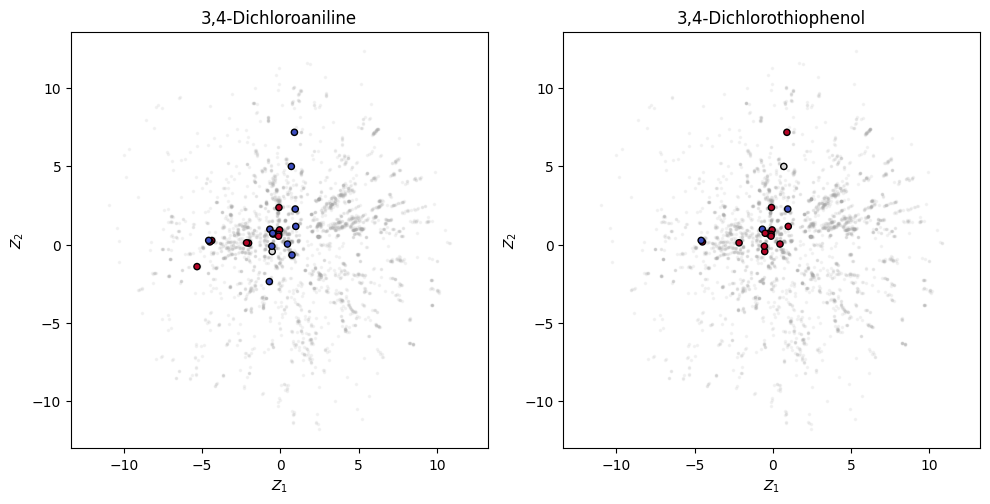

In [26]:
fig_lat, axes = plt.subplots(1, 2,figsize=(10,6))
Dataset1_test_bin = Dataset1_test[Dataset1_test.Measurement_type=='Activity_score']
# Project
for ax,substrate in zip(axes.flatten(),['3,4-Dichloroaniline', '3,4-Dichlorothiophenol']):
    subset_ = Dataset1_test_bin[(Dataset1_test_bin.Acceptor==substrate)]
    ax.scatter(subset_.mu1, subset_.mu2, c=subset_.Measurement_val.to_numpy(dtype=float), alpha=1, s=20,edgecolor='black', zorder=3,cmap='coolwarm')
    ax.set_title(substrate)
    ax.set_xlabel("$Z_1$")
    ax.set_ylabel("$Z_2$")
    ax.set_aspect('equal')
    ax.plot(msa_embeddings[:, 0], msa_embeddings[:, 1], '.', alpha=0.1, markersize=3, zorder=1,color='darkgray')
    ax.set_box_aspect(1)
plt.tight_layout()
fig_lat.savefig(os.path.join(run.results, "latent_space_with_dca_dctp.png"))


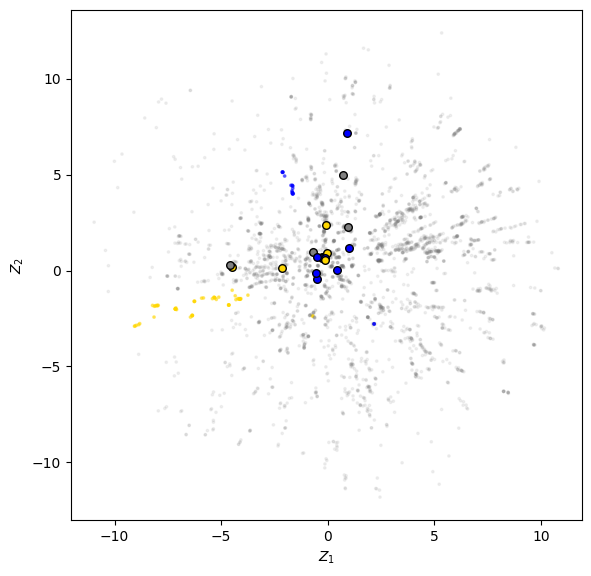

In [27]:
fig_lat, ax = plt.subplots(figsize=(6,6))

color_msa = []
alpha_msa = []
for i,label in enumerate(msa_key_label_order.values()):
    color_msa.append(color_dict[str(label.tolist())])
    alpha_msa.append(alpha_dict[str(label.tolist())])
ax.scatter(msa_embeddings[:, 0], msa_embeddings[:, 1], c=color_msa, alpha=alpha_msa, s=3, zorder=3)

for row in Dataset1_DCA_DCP_bin.itertuples():
    label = str(row.labels)
    color = color_dict[label]
    ax.scatter(row.mu1, row.mu2, color=color, alpha=1, s=30,edgecolor='black', zorder=3)

ax.set_xlabel("$Z_1$")
ax.set_ylabel("$Z_2$")


ax.set_box_aspect(1)
plt.tight_layout()
fig_lat.savefig(os.path.join(run.results, "latent_space_with_D1_DCA_DCP.png"))

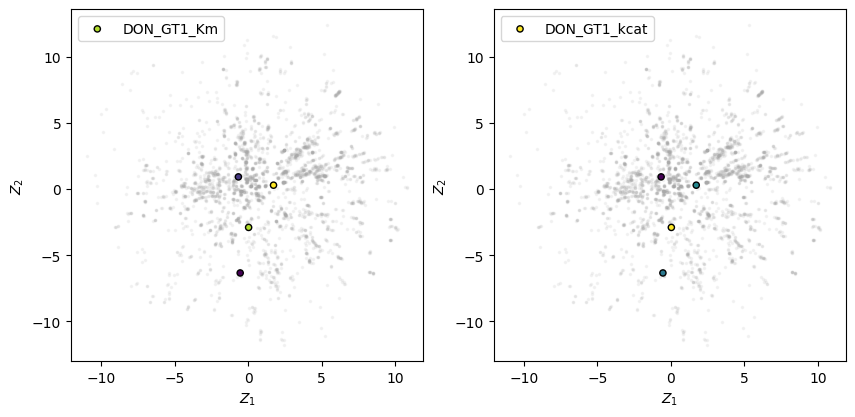

In [28]:
fig_lat, ax = plt.subplots(1, 2,figsize=(10,5))

# Project
ax[0].scatter(DON_GT1_kin_unique.mu1, DON_GT1_kin_unique.mu2, c=DON_GT1_kin[DON_GT1_kin.Measurement_type=='Km'].Measurement_val.to_numpy(dtype=float), alpha=1, s=20,edgecolor='black', zorder=2,label='DON_GT1_Km')
ax[1].scatter(DON_GT1_kin_unique.mu1, DON_GT1_kin_unique.mu2, c=DON_GT1_kin[DON_GT1_kin.Measurement_type=='kcat'].Measurement_val.to_numpy(dtype=float), alpha=1, s=20,edgecolor='black', zorder=2,label='DON_GT1_kcat')
for i in range(2):
    ax[i].plot(msa_embeddings[:, 0], msa_embeddings[:, 1], '.', alpha=0.1, markersize=3, zorder=1,color='darkgray')
    ax[i].set_xlabel("$Z_1$")
    ax[i].set_ylabel("$Z_2$")
    ax[i].legend(fontsize=10)
    ax[i].set_box_aspect(1)
    #ax[i].set_ylim(0,5)
    #ax[i].set_xlim(-10,0)
fig_lat.savefig(os.path.join(run.results, "latent_space_with_DON_GT1_kin.png"))

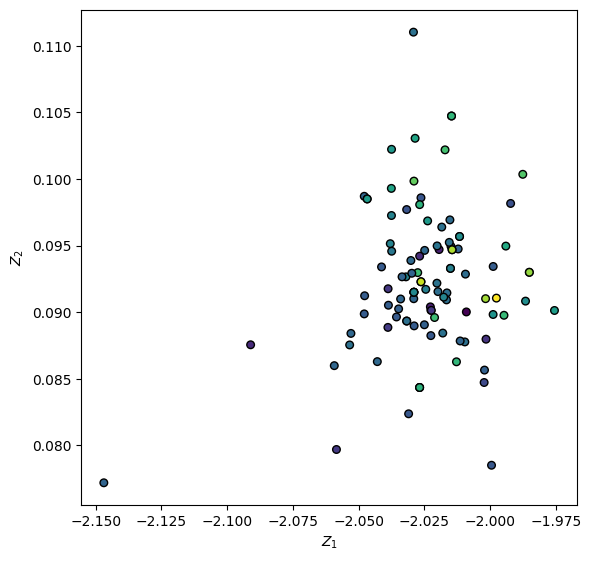

In [29]:
fig_lat, ax = plt.subplots(figsize=(6,6))
# Project

ax.scatter(PtUGT1_TMmut.mu1, PtUGT1_TMmut.mu2, c=PtUGT1_TMmut.Measurement_val.to_numpy(dtype=float), alpha=1, s=30,edgecolor='black', zorder=3)
ax.set_xlabel("$Z_1$")
ax.set_ylabel("$Z_2$")

#ax.plot(msa_embeddings[:, 0], msa_embeddings[:, 1], '.', alpha=0.1, markersize=3, zorder=1,color='darkgray')
#ax.set_xlim(-4.3,-4.35)
#ax.set_ylim(PtUGT1_TMmut.mu2.min()*0.99,0.34)
ax.set_box_aspect(1)
plt.tight_layout()
fig_lat.savefig(os.path.join(run.results, "latent_space_with_PtUGT1_TMmut.png"))

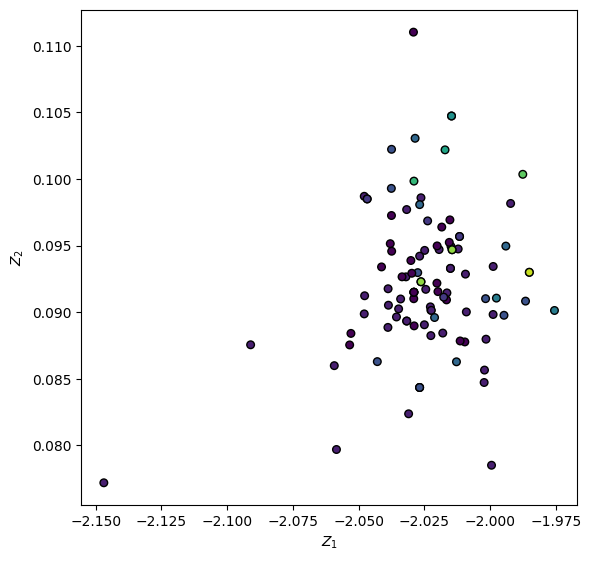

In [30]:
fig_lat, ax = plt.subplots(figsize=(6,6))
# Project

ax.scatter(PtUGT1_TMmut.mu1, PtUGT1_TMmut.mu2, c=PtUGT1_TMmut.Mutation_position.str.count(','), alpha=1, s=30,edgecolor='black', zorder=3)
ax.set_xlabel("$Z_1$")
ax.set_ylabel("$Z_2$")

#ax.plot(msa_embeddings[:, 0], msa_embeddings[:, 1], '.', alpha=0.1, markersize=3, zorder=1,color='darkgray')
#ax.set_xlim(-4.3,-4.35)
#ax.set_ylim(PtUGT1_TMmut.mu2.min()*0.99,0.34)
ax.set_box_aspect(1)
plt.tight_layout()
fig_lat.savefig(os.path.join(run.results, "latent_space_with_PtUGT1_TMmut_mutnumb.png"))

In [31]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from scipy.stats import pearsonr, spearmanr

# Prepare the data
#X = PtUGT1_TMmut[['mu1', 'mu2']]
#y = PtUGT1_TMmut['Measurement_val'].astype(float)  # Ensure the target variable is float

# Split the data into training and testing sets
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train = PtUGT1_TMmut[PtUGT1_TMmut.Mutation_position.str.count(',')<1][['mu1', 'mu2']]
y_train = PtUGT1_TMmut[PtUGT1_TMmut.Mutation_position.str.count(',')<1]['Measurement_val'].astype(float)
X_test = PtUGT1_TMmut[PtUGT1_TMmut.Mutation_position.str.count(',')>0][['mu1', 'mu2']]
y_test = PtUGT1_TMmut[PtUGT1_TMmut.Mutation_position.str.count(',')>0]['Measurement_val'].astype(float)
# Create and train the model
model = LinearRegression()
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
pearson = pearsonr(y_test, y_pred)
spearman = spearmanr(y_test, y_pred)

print(f"Mean Squared Error: {mse}")
print(f"R^2 Score: {r2}")
print(f"Pearson Correlation: {pearson[0]}")
print(f"Spearman Correlation: {spearman[0]}")

# Display the coefficients
print(f"Coefficients: {model.coef_}")
print(f"Intercept: {model.intercept_}")

Mean Squared Error: 38.82934312144688
R^2 Score: -0.07922824265831552
Pearson Correlation: 0.3739179035034665
Spearman Correlation: 0.41078312928439137
Coefficients: [ 6.3843207 41.813385 ]
Intercept: 9.49419116973877


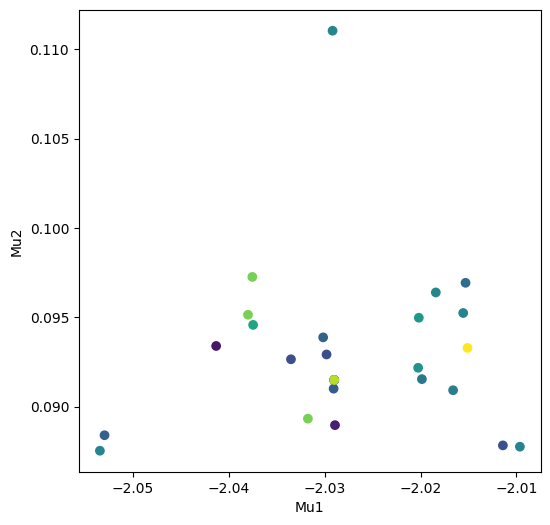

In [32]:
fig,axis = plt.subplots(1,1,figsize=(6,6))
# Plot the data
axis.scatter(X_train.iloc[:,0], X_train.iloc[:,1], label="Training points",c=y_train)
axis.set_xlabel("Mu1")
axis.set_ylabel("Mu2")
axis.set_box_aspect(1)
#axis.plot([0, 1], [1, 0], transform=axis.transAxes, ls="--", c="grey")
#axis.annotate('Pearson = {:.2f}'.format(pearson[0]), xy=(0.05, 0.9), xycoords='axes fraction')
#axis.annotate('Spearman = {:.2f}'.format(spearman[0]), xy=(0.05, 0.85), xycoords='axes fraction')
plt.savefig(os.path.join(run.results, "regression_PtUGT1_TMmut.png"))

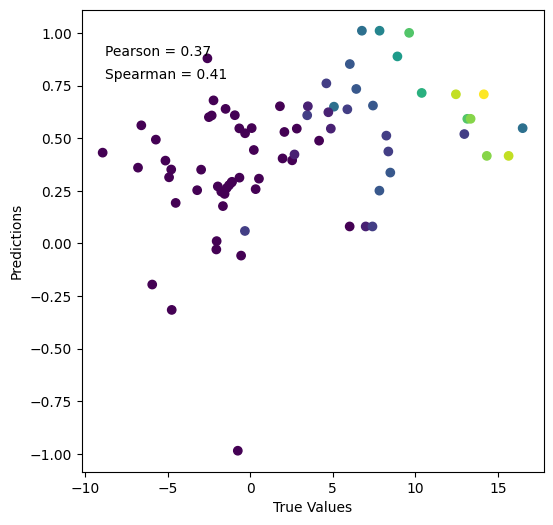

In [33]:
fig,axis = plt.subplots(1,1,figsize=(6,6))
# Plot the data
axis.scatter(y_test, y_pred, c=PtUGT1_TMmut.loc[y_test.index].Mutation_position.str.count(','))
axis.set_xlabel("True Values")
axis.set_ylabel("Predictions")
axis.set_box_aspect(1)
#axis.plot([0, 1], [1, 0], transform=axis.transAxes, ls="--", c="grey")
axis.annotate('Pearson = {:.2f}'.format(pearson[0]), xy=(0.05, 0.9), xycoords='axes fraction')
axis.annotate('Spearman = {:.2f}'.format(spearman[0]), xy=(0.05, 0.85), xycoords='axes fraction')
plt.savefig(os.path.join(run.results, "regression_PtUGT1_TMmut.png"))


Text(0.05, 0.85, 'Spearman = 0.53')

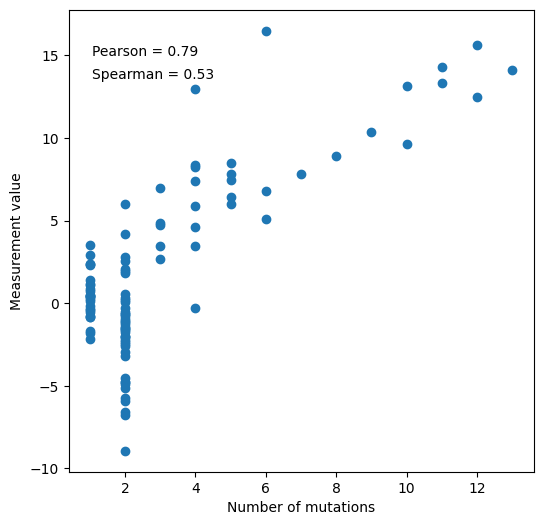

In [34]:
plt.figure(figsize=(6,6))
plt.scatter(PtUGT1_TMmut.Mutation_position.str.count(',')+1,PtUGT1_TMmut.Measurement_val.to_numpy(dtype=float))
plt.xlabel('Number of mutations')
plt.ylabel('Measurement value')
pearson_mutnumb = pearsonr(PtUGT1_TMmut.Mutation_position.str.count(','),PtUGT1_TMmut.Measurement_val.to_numpy(dtype=float))[0]
spearman_mutnumb = spearmanr(PtUGT1_TMmut.Mutation_position.str.count(','),PtUGT1_TMmut.Measurement_val.to_numpy(dtype=float))[0]
plt.annotate(f'Pearson = {pearson_mutnumb:.2f}', xy=(0.05, 0.9), xycoords='axes fraction')
plt.annotate(f'Spearman = {spearman_mutnumb:.2f}', xy=(0.05, 0.85), xycoords='axes fraction')

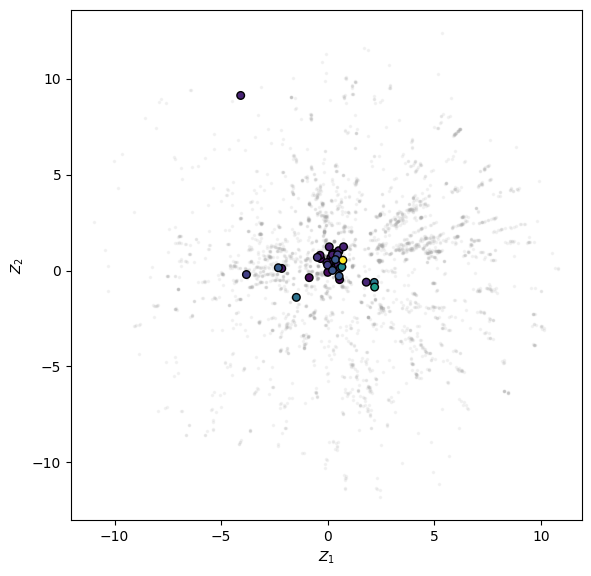

In [35]:
fig_lat, ax = plt.subplots(figsize=(6,6))
# Project
CGT_sol = CGT_sol.sort_values(by='Measurement_val')
ax.scatter(CGT_sol.mu1, CGT_sol.mu2, c=CGT_sol.Measurement_val.to_numpy(dtype=float), alpha=1, s=30,edgecolor='black', zorder=3)
ax.set_xlabel("$Z_1$")
ax.set_ylabel("$Z_2$")

ax.plot(msa_embeddings[:, 0], msa_embeddings[:, 1], '.', alpha=0.1, markersize=3, zorder=1,color='darkgray')
#ax.set_xlim(-10,5)
#ax.set_ylim(-5,11)
ax.set_box_aspect(1)
plt.tight_layout()
fig_lat.savefig(os.path.join(run.results, "latent_space_with_CGT_sol.png"))

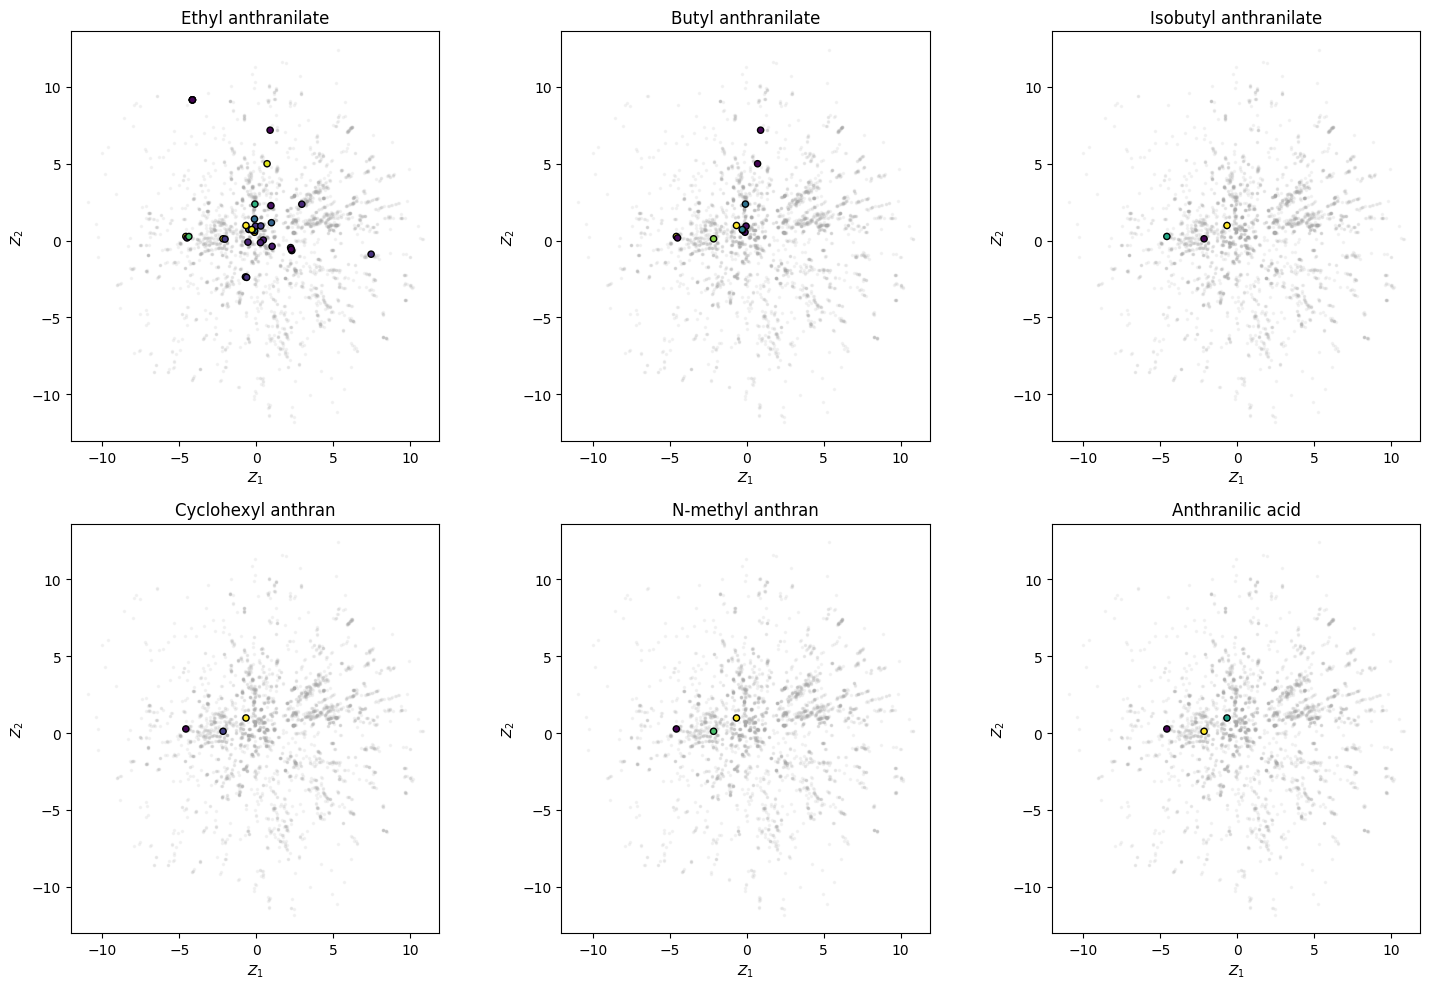

In [36]:
fig_lat, axes = plt.subplots(2, 3,figsize=(15,10))
# Project
for ax,substrate in zip(axes.flatten(),Anthranilates_GT1.Acceptor.unique()):
    subset_ = Anthranilates_GT1[(Anthranilates_GT1.Acceptor==substrate)]
    ax.scatter(subset_.mu1, subset_.mu2, c=subset_.Measurement_val.to_numpy(dtype=float), alpha=1, s=20,edgecolor='black', zorder=3)
    ax.set_title(substrate)
    ax.set_xlabel("$Z_1$")
    ax.set_ylabel("$Z_2$")
    ax.set_aspect('equal')
    ax.plot(msa_embeddings[:, 0], msa_embeddings[:, 1], '.', alpha=0.1, markersize=3, zorder=1,color='darkgray')
plt.tight_layout()
fig_lat.savefig(os.path.join(run.results, "latent_space_with_Anthranilates_GT1.png"))

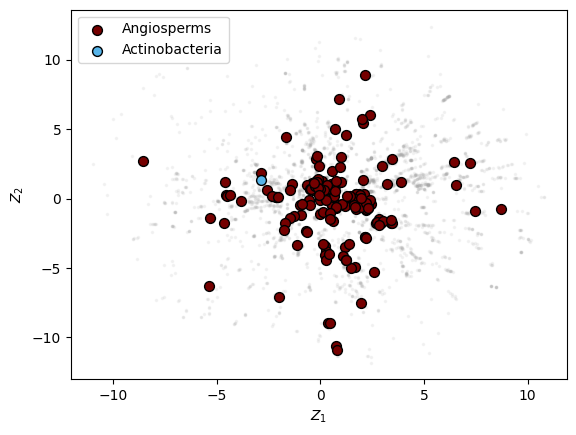

In [37]:
fig_lat, ax = plt.subplots(1, 1)

ax.plot(msa_embeddings[:, 0], msa_embeddings[:, 1], '.', alpha=0.1, markersize=3, zorder=1,color='darkgray')


# Project
for phylum in pd.unique(KnownUGT_df.Phylum):
    df_ = gaplimiter_df(KnownUGT_df[KnownUGT_df.Phylum == phylum],threshold=0.8)
    if df_.shape[0] == 0:
        continue
    mu1_ = df_.mu1
    mu2_ = df_.mu2
    ax.scatter(mu1_, mu2_, color=KnownGT_colors[phylum], alpha=1, s=50,edgecolor='black', zorder=2, label = phylum)
    #ax.annotate(str(seq_id), (seq_mu[0], seq_mu[1]))
#ax.scatter(query_coords[0::2], query_coords[1::2], color='red', alpha=1, s=20,edgecolor='black', zorder=2)
ax.set_xlabel("$Z_1$")
ax.set_ylabel("$Z_2$")
ax.legend(fontsize=10)
fig_lat.savefig(os.path.join(run.results, "latent_space_with_knownGT1_seq.png"))

### Sequence Projection for C-VAE

In [49]:
All_data_df = pd.read_csv('../../All_data.csv')
Dataset1 = All_data_df[All_data_df.ID=='Dataset1']
latent_space = LatentSpace(run)
hmm_name = 'EnzymeMiner_PtUGT1'#'PFAM201''GASP'

/Users/dahala/GitHub/VAE-enzymes/vae_notebooks/notebooks/minimal_version/latent_space.py:42: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  vae.load_state_dict(torch.load(sel

#### 2D

In [189]:
Dataset1_Dichloroaniline_bin = Dataset1[(Dataset1.Acceptor=='3,4-Dichloroaniline')&(Dataset1.Measurement_type=='Activity_score')]
with open('../datasets/Dataset1_Dichloroaniline.faa','w') as f:
    for enz,seq in zip(Dataset1_Dichloroaniline_bin['Official_name'],Dataset1_Dichloroaniline_bin['Sequence']):
        f.write(f'>{enz}\n{seq}\n')

In [190]:
Dataset1_Dichloroaniline_labels = torch.zeros(24,1)
Dataset1_Dichloroaniline_labels_neg = torch.zeros(24,1)
for i, val in enumerate(Dataset1_Dichloroaniline_bin['Measurement_val']):
    Dataset1_Dichloroaniline_labels[i,0] = 1 if float(val) == 1 else 0
    Dataset1_Dichloroaniline_labels_neg[i,0] = 1 if float(val) == 0 else 0
dataset1_bin_encode = encode_custom_seqs_conditional('Dataset1_Dichloroaniline',hmm_name,run.result,Dataset1_Dichloroaniline_labels,fasta_ext='faa',model= f'vae_fold_0.model')
Dataset1_Dichloroaniline_bin = Dataset1_Dichloroaniline_bin.merge(dataset1_bin_encode, left_on='Official_name', right_index=True)
dataset1_bin_encode_neg = encode_custom_seqs_conditional('Dataset1_Dichloroaniline',hmm_name,run.result,Dataset1_Dichloroaniline_labels_neg,fasta_ext='faa',model= f'vae_fold_0.model')
Dataset1_Dichloroaniline_bin = Dataset1_Dichloroaniline_bin.merge(dataset1_bin_encode_neg[['mu1','mu2']], left_on='Official_name', right_index=True,suffixes=('','_neg'))

/Users/dahala/GitHub/VAE-enzymes/vae_notebooks/notebooks/minimal_version/latent_space.py:42: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  vae.load_state_dict(torch.load(sel

In [14]:
Dataset1_DCP_bin = Dataset1[(Dataset1.Acceptor=='3,4-Dichlorothiophenol')&(Dataset1.Measurement_type=='Activity_score')]
with open('../datasets/Dataset1_DCP.faa','w') as f:
    for enz,seq in zip(Dataset1_DCP_bin['Official_name'],Dataset1_DCP_bin['Sequence']):
        f.write(f'>{enz}\n{seq}\n')


In [17]:
Dataset1_DCP_labels = torch.zeros(18,1)
Dataset1_DCP_labels_neg = torch.zeros(18,1)
for i, val in enumerate(Dataset1_DCP_bin['Measurement_val']):
    Dataset1_DCP_labels[i,0] = 1 if float(val) == 1 else 0
    Dataset1_DCP_labels_neg[i,0] = 1 if float(val) == 0 else 0

dataset1_bin_encode = encode_custom_seqs_conditional('Dataset1_DCP',hmm_name,run.result,Dataset1_DCP_labels,fasta_ext='faa',model= f'vae_fold_0.model')
Dataset1_DCP_bin = Dataset1_DCP_bin.merge(dataset1_bin_encode, left_on='Official_name', right_index=True)
dataset1_bin_encode_neg = encode_custom_seqs_conditional('Dataset1_DCP',hmm_name,run.result,Dataset1_DCP_labels_neg,fasta_ext='faa',model= f'vae_fold_0.model')
Dataset1_DCP_bin = Dataset1_DCP_bin.merge(dataset1_bin_encode_neg[['mu1','mu2']], left_on='Official_name', right_index=True,suffixes=('','_neg'))

/Users/dahala/GitHub/VAE-enzymes/vae_notebooks/notebooks/minimal_version/latent_space.py:42: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  vae.load_state_dict(torch.load(sel

RuntimeError: mat1 and mat2 shapes cannot be multiplied (1x9325 and 9326x444)

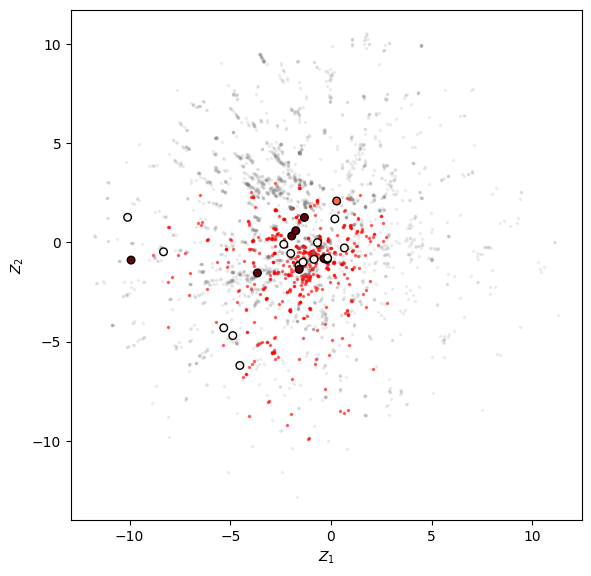

In [159]:
fig_lat, ax = plt.subplots(figsize=(6,6))
# Project
ax.scatter(Dataset1_Dichloroaniline_bin.mu1, Dataset1_Dichloroaniline_bin.mu2, c=Dataset1_Dichloroaniline_bin.Measurement_val.to_numpy(dtype=float), alpha=1, s=30,edgecolor='black', zorder=3,cmap='Reds')
ax.set_xlabel("$Z_1$")
ax.set_ylabel("$Z_2$")

conditional = True
if conditional:
    for i,label in enumerate(msa_key_label_order.values()):
        if label[0] == 1:
        #if label[0] == 0:
            ax.plot(msa_embeddings[i, 0], msa_embeddings[i, 1], '.', alpha=0.5, markersize=3, color='red')
        else:
            ax.plot(msa_embeddings[i, 0], msa_embeddings[i, 1], '.', alpha=0.1, markersize=3, color='gray')
    ax.plot(query_coords[0::2], query_coords[1::2], '.', color='k')
else:
    ax.plot(msa_embeddings[:, 0], msa_embeddings[:, 1], '.', alpha=0.1, markersize=3, )
    ax.plot(query_coords[0::2], query_coords[1::2], '.', color='red')
#ax.set_xlim(-3,3)
#ax.set_ylim(-5,2)
ax.set_box_aspect(1)
plt.tight_layout()
fig_lat.savefig(os.path.join(run.results, "latent_space_with_D1_Dichloroaniline_bin.png"))

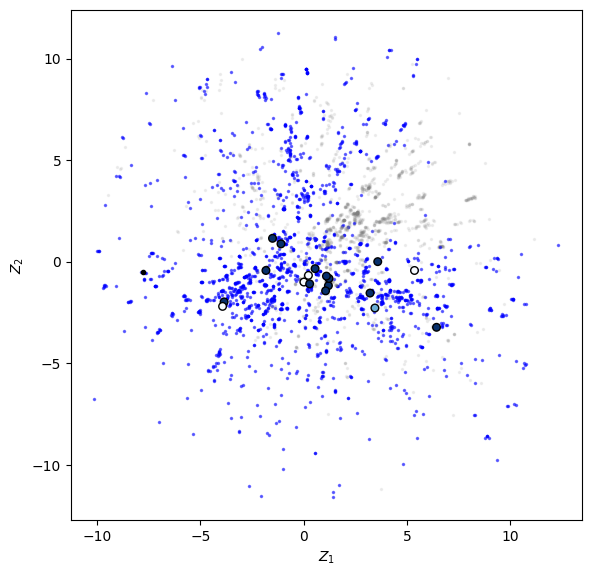

In [193]:
fig_lat, ax = plt.subplots(figsize=(6,6))
# Project
ax.scatter(Dataset1_DCP_bin.mu1, Dataset1_DCP_bin.mu2, c=Dataset1_DCP_bin.Measurement_val.to_numpy(dtype=float), alpha=1, s=30,edgecolor='black', zorder=3,cmap='Blues')
ax.set_xlabel("$Z_1$")
ax.set_ylabel("$Z_2$")

conditional = True
if conditional:
    for i,label in enumerate(msa_key_label_order.values()):
        if label[0] == 1:
        #if label[0] == 0:
            ax.plot(msa_embeddings[i, 0], msa_embeddings[i, 1], '.', alpha=0.5, markersize=3, color='blue')
        else:
            ax.plot(msa_embeddings[i, 0], msa_embeddings[i, 1], '.', alpha=0.1, markersize=3, color='grey')
    ax.plot(query_coords[0::2], query_coords[1::2], '.', color='k')
else:
    ax.plot(msa_embeddings[:, 0], msa_embeddings[:, 1], '.', alpha=0.1, markersize=3, )
    ax.plot(query_coords[0::2], query_coords[1::2], '.', color='red')
#ax.set_xlim(-3,3)
#ax.set_ylim(-5,11)
ax.set_box_aspect(1)
plt.tight_layout()
fig_lat.savefig(os.path.join(run.results, "latent_space_with_D1_DCP_bin.png"))

In [ ]:
fig_lat, ax = plt.subplots(figsize=(6,6))
# Project
Dataset1_Dichloroaniline_bin_subset = Dataset1_Dichloroaniline_bin[Dataset1_Dichloroaniline_bin.Measurement_val.to_numpy(dtype=float)==1]
ax.scatter(Dataset1_Dichloroaniline_bin_subset.mu1, Dataset1_Dichloroaniline_bin_subset.mu2, alpha=0.5, s=30,edgecolor='black', zorder=3,cmap='red')
ax.scatter(Dataset1_Dichloroaniline_bin_subset.mu1_neg, Dataset1_Dichloroaniline_bin_subset.mu2_neg, alpha=0.5, s=30,edgecolor='black', zorder=3,cmap='blue')
ax.set_xlabel("$Z_1$")
ax.set_ylabel("$Z_2$")

conditional = True
if conditional:
    for i,label in enumerate(msa_key_label_order.values()):
        #if label[0] == 0:
        if label[0] == 1:
            ax.plot(msa_embeddings[i, 0], msa_embeddings[i, 1], '.', alpha=0.1, markersize=3, color='red')
        else:
            ax.plot(msa_embeddings[i, 0], msa_embeddings[i, 1], '.', alpha=0.1, markersize=3, color='blue')
    ax.plot(query_coords[0::2], query_coords[1::2], '.', color='k')
else:
    ax.plot(msa_embeddings[:, 0], msa_embeddings[:, 1], '.', alpha=0.1, markersize=3, )
    ax.plot(query_coords[0::2], query_coords[1::2], '.', color='red')
#ax.set_xlim(-3,3)
#ax.set_ylim(-5,2)
ax.set_box_aspect(1)
plt.tight_layout()
fig_lat.savefig(os.path.join(run.results, "latent_space_with_D1_Dichloroaniline_bin_pos_reversed.png"))

In [ ]:
fig_lat, ax = plt.subplots(figsize=(6,6))
# Project
Dataset1_DCP_bin_subset = Dataset1_DCP_bin[Dataset1_DCP_bin.Measurement_val.to_numpy(dtype=float)==1]
ax.scatter(Dataset1_DCP_bin_subset.mu1, Dataset1_DCP_bin_subset.mu2, alpha=0.5, s=30,edgecolor='black', zorder=3,cmap='red')
ax.scatter(Dataset1_DCP_bin_subset.mu1_neg, Dataset1_DCP_bin_subset.mu2_neg, alpha=0.5, s=30,edgecolor='black', zorder=3,cmap='navy')
ax.set_xlabel("$Z_1$")
ax.set_ylabel("$Z_2$")

conditional = True
if conditional:
    for i,label in enumerate(msa_key_label_order.values()):
        if label[0] == 1:
        #if label[0] == 0:
            ax.plot(msa_embeddings[i, 0], msa_embeddings[i, 1], '.', alpha=0.1, markersize=3, color='red')
        else:
            ax.plot(msa_embeddings[i, 0], msa_embeddings[i, 1], '.', alpha=0.1, markersize=3, color='blue')
    ax.plot(query_coords[0::2], query_coords[1::2], '.', color='k')
else:
    ax.plot(msa_embeddings[:, 0], msa_embeddings[:, 1], '.', alpha=0.1, markersize=3, )
    ax.plot(query_coords[0::2], query_coords[1::2], '.', color='red')
#ax.set_xlim(-3,3)
#ax.set_ylim(-5,2)
ax.set_box_aspect(1)
plt.tight_layout()
fig_lat.savefig(os.path.join(run.results, "latent_space_with_D1_DCP_bin_pos_reversed.png"))

#### 2D, multi label

In [50]:
cols1 = ['Official_name', 'Sequence', 'Acceptor', 'Measurement_val']
cols2 = ['Official_name', 'Acceptor', 'Measurement_val']
Dataset1_DCA_ = Dataset1[(Dataset1.Acceptor.isin(['3,4-Dichloroaniline']))&(Dataset1.Measurement_type=='Activity_score')]
Dataset1_DCP_ = Dataset1[(Dataset1.Acceptor.isin(['3,4-Dichlorothiophenol']))&(Dataset1.Measurement_type=='Activity_score')]
Dataset1_DCA_DCP_bin = pd.merge(Dataset1_DCA_[cols1],Dataset1_DCP_[cols2],on='Official_name',suffixes=('_DCA','_DCP'))
with open('../datasets/Dataset1_DCA_DCP.faa','w') as f:
    for enz,seq in zip(Dataset1_DCA_DCP_bin['Official_name'],Dataset1_DCA_DCP_bin['Sequence']):
        f.write(f'>{enz}\n{seq}\n')


In [51]:
Dataset1_DCA_DCP_labels = torch.zeros(18,2)
for i, (val1,val2) in enumerate(zip(Dataset1_DCA_DCP_bin['Measurement_val_DCA'],Dataset1_DCA_DCP_bin['Measurement_val_DCP'])):
    Dataset1_DCA_DCP_labels[i,0] = 1 if float(val1) == 1 else 0
    Dataset1_DCA_DCP_labels[i,1] = 1 if float(val2) == 1 else 0
Dataset1_DCA_DCP_bin['labels'] = Dataset1_DCA_DCP_labels.tolist()

In [52]:
encode_ = encode_custom_seqs_conditional('Dataset1_DCA_DCP',hmm_name,run.result,Dataset1_DCA_DCP_labels,fasta_ext='faa',model= f'vae_fold_0.model')
Dataset1_DCA_DCP_bin = Dataset1_DCA_DCP_bin.merge(encode_, left_on='Official_name', right_index=True)

/Users/dahala/GitHub/VAE-enzymes/vae_notebooks/notebooks/minimal_version/latent_space.py:42: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  vae.load_state_dict(torch.load(sel

In [38]:
Dataset1_DCA_DCP_labels_none = torch.zeros(18,2)
Dataset1_DCA_DCP_labels_both = torch.ones(18,2)
Dataset1_DCA_DCP_labels_DCA = torch.zeros(18,2)
Dataset1_DCA_DCP_labels_DCA[:,0] = 1
Dataset1_DCA_DCP_labels_DCP = torch.zeros(18,2)
Dataset1_DCA_DCP_labels_DCP[:,1] = 1

In [39]:
encode_none = encode_custom_seqs_conditional('Dataset1_DCA_DCP',hmm_name,run.result,Dataset1_DCA_DCP_labels_none,fasta_ext='faa',model= f'vae_fold_0.model')
encode_both = encode_custom_seqs_conditional('Dataset1_DCA_DCP',hmm_name,run.result,Dataset1_DCA_DCP_labels_both,fasta_ext='faa',model= f'vae_fold_0.model')
encode_DCA = encode_custom_seqs_conditional('Dataset1_DCA_DCP',hmm_name,run.result,Dataset1_DCA_DCP_labels_DCA,fasta_ext='faa',model= f'vae_fold_0.model')
encode_DCP = encode_custom_seqs_conditional('Dataset1_DCA_DCP',hmm_name,run.result,Dataset1_DCA_DCP_labels_DCP,fasta_ext='faa',model= f'vae_fold_0.model')
Dataset1_DCA_DCP_bin = Dataset1_DCA_DCP_bin.merge(encode_none, left_on='Official_name', right_index=True,suffixes=('','_none'))
Dataset1_DCA_DCP_bin = Dataset1_DCA_DCP_bin.merge(encode_both, left_on='Official_name', right_index=True,suffixes=('','_both'))
Dataset1_DCA_DCP_bin = Dataset1_DCA_DCP_bin.merge(encode_DCA, left_on='Official_name', right_index=True,suffixes=('','_DCA'))
Dataset1_DCA_DCP_bin = Dataset1_DCA_DCP_bin.merge(encode_DCP, left_on='Official_name', right_index=True,suffixes=('','_DCP'))
Dataset1_DCA_DCP_bin['labels_none'] = Dataset1_DCA_DCP_labels_none.tolist()
Dataset1_DCA_DCP_bin['labels_both'] = Dataset1_DCA_DCP_labels_both.tolist()
Dataset1_DCA_DCP_bin['labels_DCA'] = Dataset1_DCA_DCP_labels_DCA.tolist()
Dataset1_DCA_DCP_bin['labels_DCP'] = Dataset1_DCA_DCP_labels_DCP.tolist()


/Users/dahala/GitHub/VAE-enzymes/vae_notebooks/notebooks/minimal_version/latent_space.py:42: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  vae.load_state_dict(torch.load(sel

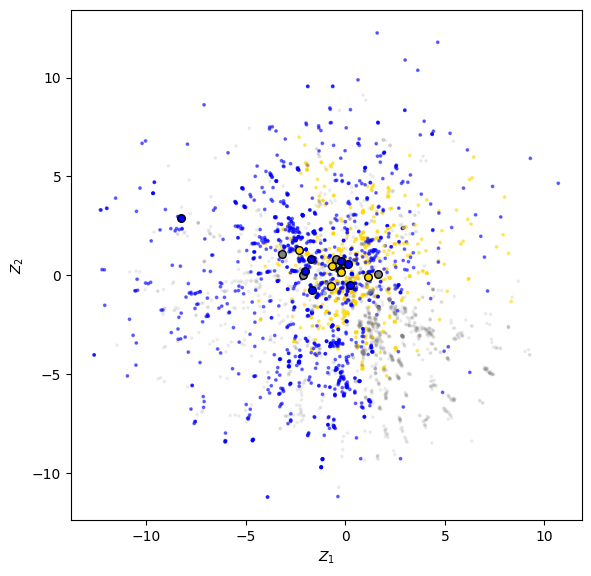

In [40]:
fig_lat, ax = plt.subplots(figsize=(6,6))

color_msa = []
alpha_msa = []
for i,label in enumerate(msa_key_label_order.values()):
    color_msa.append(color_dict[str(label.tolist())])
    alpha_msa.append(alpha_dict[str(label.tolist())])
ax.scatter(msa_embeddings[:, 0], msa_embeddings[:, 1], c=color_msa, alpha=alpha_msa, s=3, zorder=3)

for row in Dataset1_DCA_DCP_bin.itertuples():
    label = str(row.labels)
    color = color_dict[label]
    ax.scatter(row.mu1, row.mu2, color=color, alpha=1, s=30,edgecolor='black', zorder=3)

ax.set_xlabel("$Z_1$")
ax.set_ylabel("$Z_2$")


ax.set_box_aspect(1)
plt.tight_layout()
fig_lat.savefig(os.path.join(run.results, "latent_space_with_D1_DCA_DCP.png"))

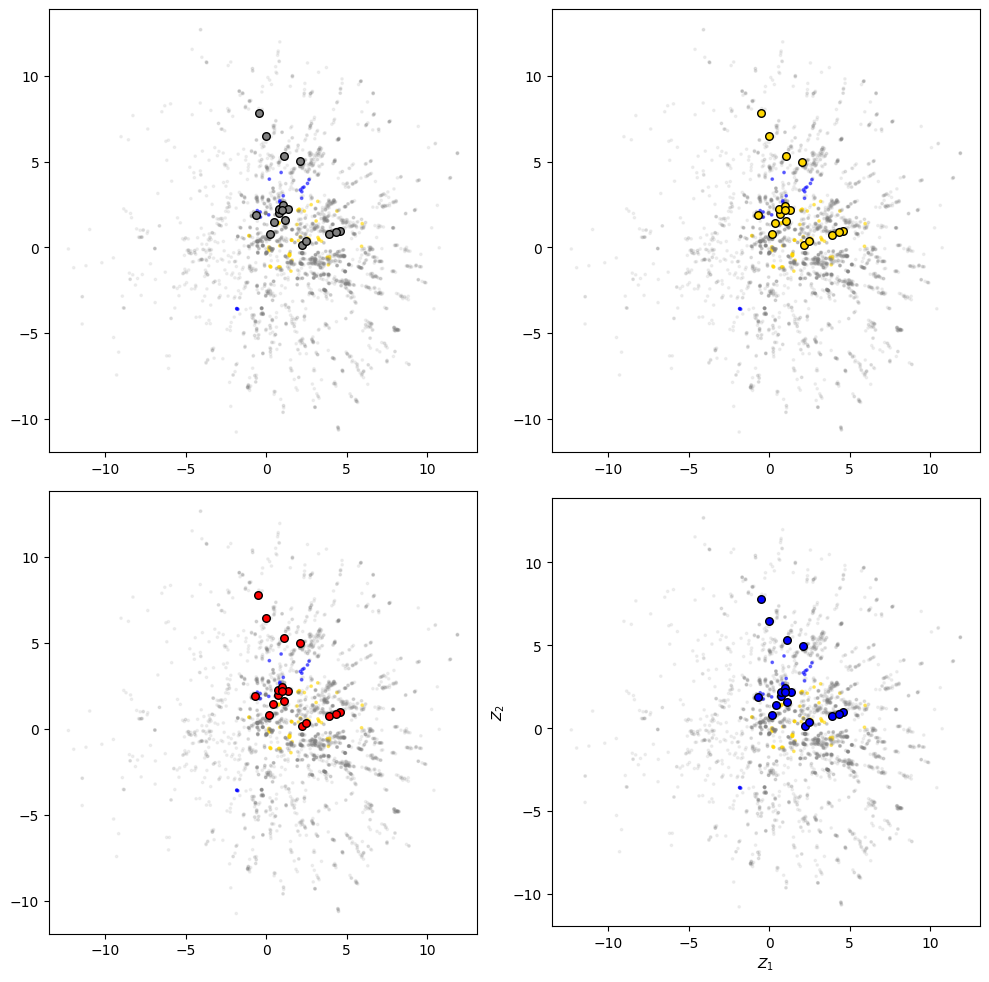

In [15]:
fig_lat, axes = plt.subplots(nrows=2, ncols=2,figsize=(10,10))

for ax,cat in zip(axes.flatten(), ['none','both','DCA','DCP']):
    ax.scatter(msa_embeddings[:, 0], msa_embeddings[:, 1], c=color_msa, alpha=alpha_msa, s=3, zorder=3)


    for i in range(18):
        label = str(Dataset1_DCA_DCP_bin.loc[i,f'labels_{cat}'])
        color = color_dict[label]
        ax.scatter(Dataset1_DCA_DCP_bin.loc[i,f'mu1_{cat}'], Dataset1_DCA_DCP_bin.loc[i,f'mu2_{cat}'], color=color, alpha=1, s=30,edgecolor='black', zorder=3)

ax.set_xlabel("$Z_1$")
ax.set_ylabel("$Z_2$")


ax.set_box_aspect(1)
plt.tight_layout()
fig_lat.savefig(os.path.join(run.results, "latent_space_with_D1_DCA_DCP_none.png"))

#### 3D

In [135]:
Dataset1_Dichloroaniline_labels = torch.zeros(24,1)
Dataset1_Dichloroaniline_labels_neg = torch.zeros(24,1)
for i, val in enumerate(Dataset1_Dichloroaniline_bin['Measurement_val']):
    Dataset1_Dichloroaniline_labels[i,0] = 1 if float(val) == 1 else 0
    Dataset1_Dichloroaniline_labels_neg[i,0] = 1 if float(val) == 0 else 0
with open('../datasets/Dataset1_Dichloroaniline.faa','w') as f:
    for enz,seq in zip(Dataset1_Dichloroaniline_bin['Official_name'],Dataset1_Dichloroaniline_bin['Sequence']):
        f.write(f'>{enz}\n{seq}\n')
dataset1_bin_encode = encode_custom_seqs_conditional_3D('Dataset1_Dichloroaniline',hmm_name,run.result,Dataset1_Dichloroaniline_labels,fasta_ext='faa',model= f'vae_fold_0.model')
Dataset1_Dichloroaniline_bin = Dataset1_Dichloroaniline_bin.merge(dataset1_bin_encode, left_on='Official_name', right_index=True)
dataset1_bin_encode_neg = encode_custom_seqs_conditional_3D('Dataset1_Dichloroaniline',hmm_name,run.result,Dataset1_Dichloroaniline_labels_neg,fasta_ext='faa',model= f'vae_fold_0.model')
Dataset1_Dichloroaniline_bin = Dataset1_Dichloroaniline_bin.merge(dataset1_bin_encode_neg[['mu1','mu2','mu3']], left_on='Official_name', right_index=True,suffixes=('','_neg'))

NameError: name 'Dataset1_Dichloroaniline_bin' is not defined

In [136]:
Dataset1_DCP_bin = Dataset1[(Dataset1.Acceptor=='3,4-Dichlorothiophenol')&(Dataset1.Measurement_type=='Activity_score')]
Dataset1_DCP_labels = torch.zeros(18,1)
Dataset1_DCP_labels_neg = torch.zeros(18,1)
for i, val in enumerate(Dataset1_DCP_bin['Measurement_val']):
    Dataset1_DCP_labels[i,0] = 1 if float(val1) == 1 else 0
    Dataset1_DCP_labels_neg[i,0] = 1 if float(val1) == 0 else 0
with open('../datasets/Dataset1_DCP.faa','w') as f:
    for enz,seq in zip(Dataset1_DCP_bin['Official_name'],Dataset1_DCP_bin['Sequence']):
        f.write(f'>{enz}\n{seq}\n')
dataset1_bin_encode = encode_custom_seqs_conditional_3D('Dataset1_DCP',hmm_name,run.result,Dataset1_DCP_labels,fasta_ext='faa',model= f'vae_fold_0.model')
Dataset1_DCP_bin = Dataset1_DCP_bin.merge(dataset1_bin_encode, left_on='Official_name', right_index=True)
dataset1_bin_encode_neg = encode_custom_seqs_conditional_3D('Dataset1_DCP',hmm_name,run.result,Dataset1_DCP_labels_neg,fasta_ext='faa',model= f'vae_fold_0.model')
Dataset1_DCP_bin = Dataset1_DCP_bin.merge(dataset1_bin_encode_neg[['mu1','mu2','mu3']], left_on='Official_name', right_index=True,suffixes=('','_neg'))

/Users/dahala/GitHub/VAE-enzymes/vae_notebooks/notebooks/minimal_version/latent_space.py:42: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  vae.load_state_dict(torch.load(sel

/Users/dahala/GitHub/VAE-enzymes/vae_notebooks/notebooks/minimal_version/latent_space.py:42: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  vae.load_state_dict(torch.load(sel

NameError: name 'Dataset1_Dichloroaniline_bin' is not defined

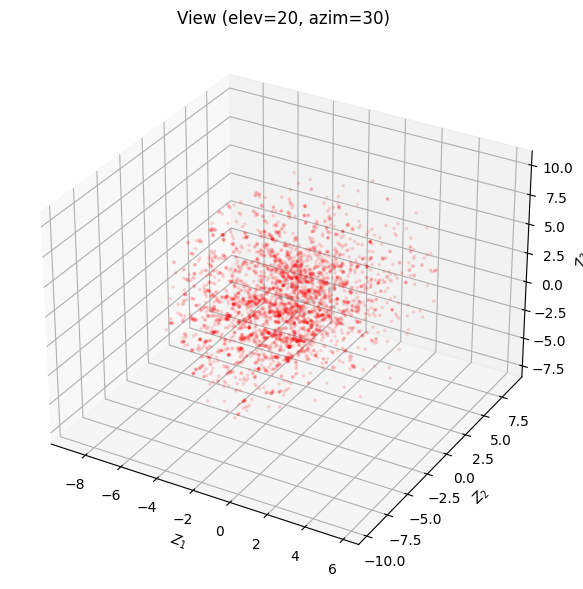

In [137]:
# Projection to the latent space
# Show your queries
#run.weights = f'{run.result}/model/vae_fold_0_e9999.model'
latent_space = LatentSpace(run)
msa_embeddings = latent_space.msa_embeddings["mus"]


query_coords = latent_space.key_to_embedding(run.fixed_sequences)


conditional = True
# Prepare arrays to store points for each label
red_points = []
blue_points = []

if conditional:
    for i, label in enumerate(msa_key_label_order.values()):
        if label[0] == 0:
        #if label[0] == 1:
            red_points.append(msa_embeddings[i].numpy())
        else:
            blue_points.append(msa_embeddings[i].numpy())

# Convert to NumPy arrays for easier handling
red_points = np.array(red_points)
blue_points = np.array(blue_points)

angles = [(20, 30), (20, 80), (20, 130), (20, 180), (20, 240), (90, 0)]

# Create a figure with 4 subplots for different angles
fig = plt.figure(figsize=(24, 18))

for idx, (elev, azim) in enumerate(angles):
    ax = fig.add_subplot(2, 3, idx + 1, projection='3d')
    
    
    # Plot all red points in one scatter call
    if red_points.size > 0:
        ax.scatter(red_points[:, 0], red_points[:, 1], red_points[:, 2], alpha=0.1, s=3, color='red')

    # Plot all blue points in one scatter call
    if blue_points.size > 0:
        ax.scatter(blue_points[:, 0], blue_points[:, 1], blue_points[:, 2], alpha=0.1, s=3, color='grey')

    # Set labels and title for each subplot
    ax.set_xlabel("$Z_1$")
    ax.set_ylabel("$Z_2$")
    ax.set_zlabel("$Z_3$")
    ax.set_title(f"View (elev={elev}, azim={azim})")

    # Plot Validation Data
    ax.scatter(Dataset1_Dichloroaniline_bin.mu1, Dataset1_Dichloroaniline_bin.mu2, Dataset1_Dichloroaniline_bin.mu3, c=Dataset1_Dichloroaniline_bin.Measurement_val.to_numpy(dtype=float), alpha=1, s=30,edgecolor='black', zorder=3,cmap='coolwarm')

    # Set the view angle
    ax.view_init(elev=elev, azim=azim)

# Adjust layout
plt.tight_layout()
plt.savefig(os.path.join(run.results, f"latent_space_3d_wDCA.png"))
plt.show()

In [138]:
# Projection to the latent space
# Show your queries
#run.weights = f'{run.result}/model/vae_fold_0_e9999.model'
latent_space = LatentSpace(run)
msa_embeddings = latent_space.msa_embeddings["mus"]


query_coords = latent_space.key_to_embedding(run.fixed_sequences)


conditional = True
# Prepare arrays to store points for each label
red_points = []
blue_points = []

if conditional:
    for i, label in enumerate(msa_key_label_order.values()):
        if label[0] == 0:
        #if label[0] == 1:
            red_points.append(msa_embeddings[i].numpy())
        else:
            blue_points.append(msa_embeddings[i].numpy())

# Convert to NumPy arrays for easier handling
red_points = np.array(red_points)
blue_points = np.array(blue_points)

angles = [(20, 30), (20, 80), (20, 130), (20, 180), (20, 240), (90, 0)]
Dataset1_Dichloroaniline_bin_subset = Dataset1_Dichloroaniline_bin[Dataset1_Dichloroaniline_bin.Measurement_val.to_numpy(dtype=float)==1]
# Create a figure with 4 subplots for different angles
fig = plt.figure(figsize=(24, 18))

for idx, (elev, azim) in enumerate(angles):
    ax = fig.add_subplot(2, 3, idx + 1, projection='3d')
    
    
    # Plot all red points in one scatter call
    if red_points.size > 0:
        ax.scatter(red_points[:, 0], red_points[:, 1], red_points[:, 2], alpha=0.1, s=3, color='blue')

    # Plot all blue points in one scatter call
    if blue_points.size > 0:
        ax.scatter(blue_points[:, 0], blue_points[:, 1], blue_points[:, 2], alpha=0.1, s=3, color='grey')

    # Set labels and title for each subplot
    ax.set_xlabel("$Z_1$")
    ax.set_ylabel("$Z_2$")
    ax.set_zlabel("$Z_3$")
    ax.set_title(f"View (elev={elev}, azim={azim})")
    
    # Plot Validation Data
    ax.scatter(Dataset1_Dichloroaniline_bin_subset.mu1, Dataset1_Dichloroaniline_bin_subset.mu2, Dataset1_Dichloroaniline_bin_subset.mu3, alpha=0.8, s=30,edgecolor='black', zorder=1,color='red')
    #ax.scatter(Dataset1_Dichloroaniline_bin_subset.mu1_neg, Dataset1_Dichloroaniline_bin_subset.mu2_neg, Dataset1_Dichloroaniline_bin_subset.mu3_neg, alpha=0.8, s=30,edgecolor='black', zorder=4,color='blue')

    # Set the view angle
    ax.view_init(elev=elev, azim=azim)

# Adjust layout
plt.tight_layout()
plt.savefig(os.path.join(run.results, f"latent_space_3d_wDCA_pos_reversed.png"))
plt.show()

NameError: name 'Dataset1_Dichloroaniline_bin' is not defined

In [ ]:
# Projection to the latent space
# Show your queries
#run.weights = f'{run.result}/model/vae_fold_0_e9999.model'
latent_space = LatentSpace(run)
msa_embeddings = latent_space.msa_embeddings["mus"]


query_coords = latent_space.key_to_embedding(run.fixed_sequences)


conditional = True
# Prepare arrays to store points for each label
red_points = []
blue_points = []

if conditional:
    for i, label in enumerate(msa_key_label_order.values()):
        if label[0] == 0:
        #if label[0] == 1:
            red_points.append(msa_embeddings[i].numpy())
        else:
            blue_points.append(msa_embeddings[i].numpy())

# Convert to NumPy arrays for easier handling
red_points = np.array(red_points)
blue_points = np.array(blue_points)

angles = [(20, 30), (20, 80), (20, 130), (20, 180), (20, 240), (90, 0)]
Dataset1_Dichloroaniline_bin_subset = Dataset1_Dichloroaniline_bin[Dataset1_Dichloroaniline_bin.Measurement_val.to_numpy(dtype=float)==0]
# Create a figure with 4 subplots for different angles
fig = plt.figure(figsize=(24, 18))

for idx, (elev, azim) in enumerate(angles):
    ax = fig.add_subplot(2, 3, idx + 1, projection='3d')
    
    
    # Plot all red points in one scatter call
    if red_points.size > 0:
        ax.scatter(red_points[:, 0], red_points[:, 1], red_points[:, 2], alpha=0.1, s=3, color='red')

    # Plot all blue points in one scatter call
    if blue_points.size > 0:
        ax.scatter(blue_points[:, 0], blue_points[:, 1], blue_points[:, 2], alpha=0.1, s=3, color='blue')

    # Set labels and title for each subplot
    ax.set_xlabel("$Z_1$")
    ax.set_ylabel("$Z_2$")
    ax.set_zlabel("$Z_3$")
    ax.set_title(f"View (elev={elev}, azim={azim})")
    
    # Plot Validation Data
    ax.scatter(Dataset1_Dichloroaniline_bin_subset.mu1, Dataset1_Dichloroaniline_bin_subset.mu2, Dataset1_Dichloroaniline_bin_subset.mu3, alpha=0.8, s=30,edgecolor='black', zorder=1,color='blue')
    ax.scatter(Dataset1_Dichloroaniline_bin_subset.mu1_neg, Dataset1_Dichloroaniline_bin_subset.mu2_neg, Dataset1_Dichloroaniline_bin_subset.mu3_neg, alpha=0.8, s=30,edgecolor='black', zorder=4,color='red')

    # Set the view angle
    ax.view_init(elev=elev, azim=azim)

# Adjust layout
plt.tight_layout()
plt.savefig(os.path.join(run.results, f"latent_space_3d_wDCA_neg_reversed.png"))
plt.show()

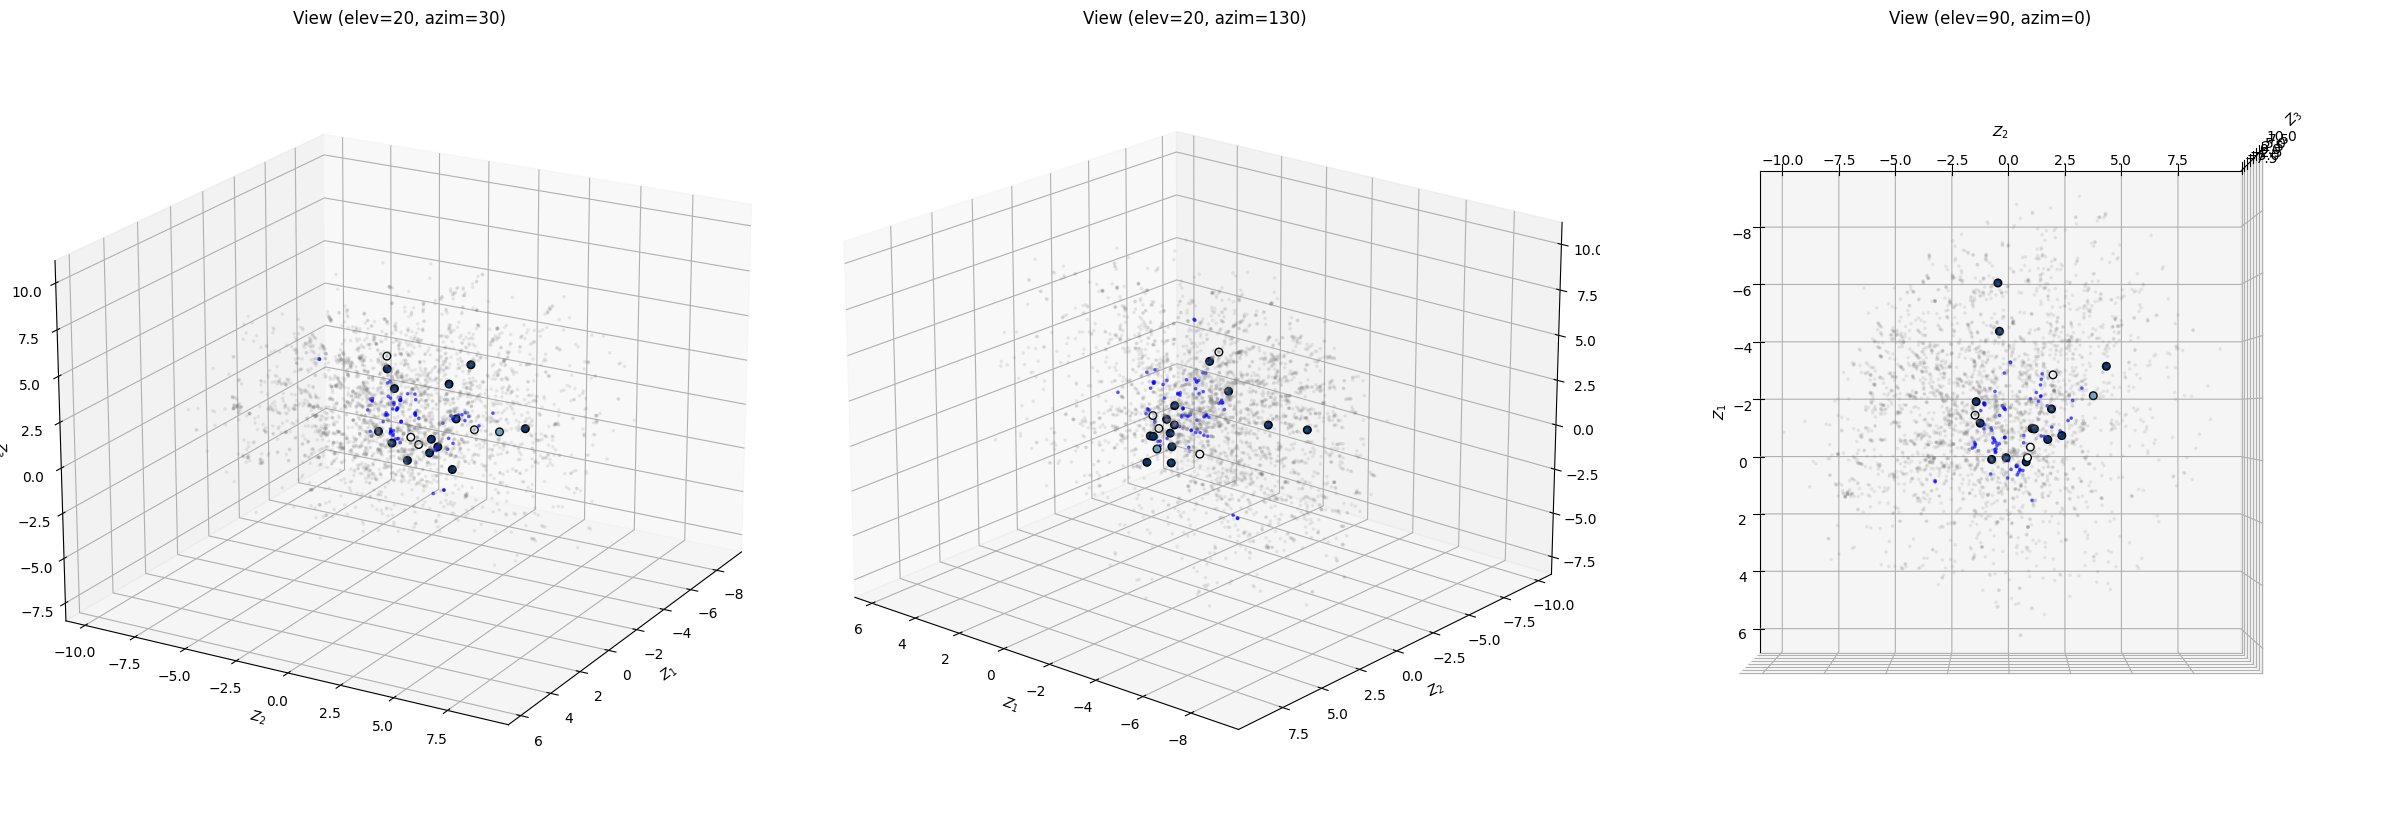

In [146]:
# Projection to the latent space
# Show your queries
#run.weights = f'{run.result}/model/vae_fold_0_e9999.model'
latent_space = LatentSpace(run)
msa_embeddings = latent_space.msa_embeddings["mus"]


query_coords = latent_space.key_to_embedding(run.fixed_sequences)


conditional = True
# Prepare arrays to store points for each label
red_points = []
blue_points = []

if conditional:
    for i, label in enumerate(msa_key_label_order.values()):
        if label[0] == 1:
        #if label[0] == 1:
            red_points.append(msa_embeddings[i].numpy())
        else:
            blue_points.append(msa_embeddings[i].numpy())

# Convert to NumPy arrays for easier handling
red_points = np.array(red_points)
blue_points = np.array(blue_points)

#angles = [(20, 30), (20, 80), (20, 130), (20, 180), (20, 240), (90, 0)]
angles = [(20, 30), (20, 130), (90, 0)]
# Create a figure with 4 subplots for different angles
fig = plt.figure(figsize=(24, 18))

for idx, (elev, azim) in enumerate(angles):
    ax = fig.add_subplot(2, 3, idx + 1, projection='3d')
    
    
    # Plot all red points in one scatter call
    if red_points.size > 0:
        ax.scatter(red_points[:, 0], red_points[:, 1], red_points[:, 2], alpha=0.5, s=3, color='blue')

    # Plot all blue points in one scatter call
    if blue_points.size > 0:
        ax.scatter(blue_points[:, 0], blue_points[:, 1], blue_points[:, 2], alpha=0.1, s=3, color='grey')

    # Set labels and title for each subplot
    ax.set_xlabel("$Z_1$")
    ax.set_ylabel("$Z_2$")
    ax.set_zlabel("$Z_3$")
    ax.set_title(f"View (elev={elev}, azim={azim})")

    # Plot Validation Data
    ax.scatter(Dataset1_DCP_bin.mu1, Dataset1_DCP_bin.mu2, Dataset1_DCP_bin.mu3, c=Dataset1_DCP_bin.Measurement_val.to_numpy(dtype=float), alpha=1, s=30,edgecolor='black', zorder=3,cmap='Blues')

    # Set the view angle
    ax.view_init(elev=elev, azim=azim)

# Adjust layout
plt.tight_layout()
plt.savefig(os.path.join(run.results, f"latent_space_3d_wDCP.png"))
plt.show()

### Taxonomy Examination

In [121]:
run.result

'../results/pfam201_filtered_hmm/'

In [122]:
PFAM_UniProt_GT_filter = pd.read_csv('../../random_data/PFAM_UniProt_GT_filter.csv',index_col=0)
msa_taxonomy = []
for protein in SeqIO.parse(f'{run.result}/msa/training_msa.fasta', "fasta"):
    protein_name = protein.id
    prot_id = protein_name.split('|')[0]
    if prot_id in PFAM_UniProt_GT_filter.index:
        msa_taxonomy.append([protein_name,PFAM_UniProt_GT_filter.loc[prot_id].superkingdom,PFAM_UniProt_GT_filter.loc[prot_id].kingdom,PFAM_UniProt_GT_filter.loc[prot_id].phylum,PFAM_UniProt_GT_filter.loc[prot_id]['class'],PFAM_UniProt_GT_filter.loc[prot_id].order,PFAM_UniProt_GT_filter.loc[prot_id].family,PFAM_UniProt_GT_filter.loc[prot_id].genus,PFAM_UniProt_GT_filter.loc[prot_id]['EC number'],PFAM_UniProt_GT_filter.loc[prot_id]['Gene Ontology (GO)']])
msa_taxonomy = pd.DataFrame(msa_taxonomy,columns=['UniProt','superkingdom','kingdom','phylum','class','order','family','genus','EC','GO'])
msa_taxonomy = msa_taxonomy.set_index('UniProt')

In [123]:
All_data_df.groupby('Acceptor').count().T['3,4-Dichlorothiophenol']

ID                   36
Generator            36
Year                 36
Assay                36
Official_name        36
Combined_name        36
UGT_ID               32
Accession            36
Internal_name        36
Organism             36
Type                 36
Sequence             36
Nterm_sequence        0
Mutation_position     0
Donor                36
Donor_cid            36
Acceptor_cid         36
Measurement_type     36
Measurement_unit     36
Measurement_val      36
Measurement_std       0
Name: 3,4-Dichlorothiophenol, dtype: int64

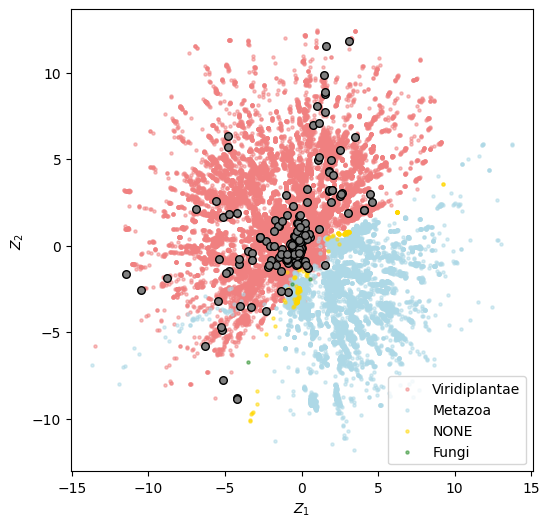

In [130]:


msa_embeddings = latent_space.msa_embeddings["mus"]
colors_kingdom = ['lightcoral','lightblue','gold','forestgreen']
fig_lat, ax = plt.subplots(1, 1,figsize=(6,6))
ax.scatter(All_data_unique.mu1, All_data_unique.mu2, color='gray', alpha=1, s=30,edgecolor='black', zorder=3)
custom_sequences = []  # give keys to MSA and embed them to the latent space
for i,kingdom in enumerate(pd.unique(msa_taxonomy.kingdom)):
    msa_filter = msa_taxonomy[msa_taxonomy.kingdom == kingdom]
    msa_filter_coords = latent_space.key_to_embedding(msa_filter.index)
    ax.scatter(msa_filter_coords[0::2], msa_filter_coords[1::2], color=colors_kingdom[i], alpha=0.5, s=5, zorder=2, label = kingdom)

#ax.plot(msa_embeddings[:, 0], msa_embeddings[:, 1], '.', alpha=0.1, markersize=3, )
#ax.plot(query_coords[0::2], query_coords[1::2], '.', color='red')
ax.legend(fontsize=10)
ax.set_xlabel("$Z_1$")
ax.set_ylabel("$Z_2$")
ax.set_box_aspect(1)
#ax.set_title(f"Latent space projection, Kingdoms, Experimental Enzymes")
fig_lat.savefig(os.path.join(run.results, f"latent_space_kingdom_exp_enz.png"))

In [ ]:
msa_taxonomy

In [ ]:
for epoch in range(1,15000):
    if (epoch + 1) % 5000 == 0:
        run.weights = f'{run.result}model/vae_fold_0_e{epoch}.model'
        latent_space = LatentSpace(run)
        msa_embeddings = latent_space.msa_embeddings["mus"]
        colors_kingdom = ['lightcoral','lightblue','gold','forestgreen']
        fig_lat, ax = plt.subplots(1, 1)
        custom_sequences = []  # give keys to MSA and embed them to the latent space
        for i,kingdom in enumerate(pd.unique(msa_taxonomy.kingdom)):
            msa_filter = msa_taxonomy[msa_taxonomy.kingdom == kingdom]
            msa_filter_coords = latent_space.key_to_embedding(msa_filter.index)
            ax.scatter(msa_filter_coords[0::2], msa_filter_coords[1::2], color=colors_kingdom[i], alpha=0.5, s=5, zorder=2, label = kingdom)

        #ax.plot(msa_embeddings[:, 0], msa_embeddings[:, 1], '.', alpha=0.1, markersize=3, )
        #ax.plot(query_coords[0::2], query_coords[1::2], '.', color='red')
        ax.legend(fontsize=10)
        ax.set_xlabel("$Z_1$")
        ax.set_ylabel("$Z_2$")
        ax.set_title(f"Latent space projection epoch {epoch}, Kingdom")
        fig_lat.savefig(os.path.join(run.results, f"latent_space_e{epoch}_kingdom.png"))

In [ ]:
#run.weights = f'{run.results[:-7]}model/vae_fold_0_e2999.model'
latent_space = LatentSpace(run)
#msa_embeddings = latent_space.msa_embeddings["mus"]
colors_kingdom = ['lightcoral','lightblue','gold','forestgreen','lightgreen','darkorange','purple','pink','brown','gray','black','red','blue','green','orange','violet','cyan','magenta','yellow','darkred','darkblue','darkgreen','darkorange','darkviolet','darkcyan','darkmagenta','maroon','navy','olive','teal','fuchsia','silver','lime','aqua','white','lightgray','gray','black']
#fig_lat, ax = plt.subplots(1, 1)
fig_lat, axes = plt.subplots(2, 2, figsize=(12, 12),sharex=True,sharey=True)
custom_sequences = []  # give keys to MSA and embed them to the latent space
for i,kingdom in enumerate(pd.unique(msa_taxonomy.kingdom)):
    ax = axes[i//2,i%2]
    msa_kingdoms = msa_taxonomy[msa_taxonomy.kingdom == kingdom]
    for i,phylum in enumerate(pd.unique(msa_kingdoms['phylum'])):
        msa_filter = msa_kingdoms[msa_kingdoms['phylum'] == phylum]
        msa_filter_coords = latent_space.key_to_embedding(msa_filter.index)
        ax.scatter(msa_filter_coords[0::2], msa_filter_coords[1::2], color=colors_kingdom[i], alpha=0.5, s=5, zorder=2, label = phylum)

#ax.plot(msa_embeddings[:, 0], msa_embeddings[:, 1], '.', alpha=0.1, markersize=3, )
#ax.plot(query_coords[0::2], query_coords[1::2], '.', color='red')
    ax.legend(fontsize=10)
    ax.set_xlabel("$Z_1$")
    ax.set_ylabel("$Z_2$")
    ax.set_title(f'{kingdom}')
fig_lat.suptitle(f"Latent space projection final, phylum",x=0.5, y=1.02)
plt.tight_layout()
fig_lat.savefig(os.path.join(run.results, f"latent_space_kingdom_phylum.png"))

In [ ]:
msa_filter_coords = latent_space.key_to_embedding(msa_metazoa.index)
coords_z1 = msa_filter_coords[0::2]
coords_z2 = msa_filter_coords[1::2]
mask_ = ((coords_z1<4) & (coords_z2>5))
for id in msa_metazoa.iloc[mask_,:].index.str.split('|').str[0]:
    print(id)


### Projection Performance Quantification

In [53]:
real_labels_DCA = pd.read_csv('../GASP_predictions/pred_blosum62Amb_Dataset1_sequences_7257.tsv',sep='\t',header=1)
real_labels_DCA['bin'] = real_labels_DCA.pred.apply(lambda x: 1 if x >= run.prob_threshold else 0)
real_labels_DCA = real_labels_DCA[real_labels_DCA.enzyme.isin(Dataset1_Dichloroaniline_bin.Official_name.to_list())]
real_labels_DCTP = pd.read_csv('../GASP_predictions/pred_blosum62Amb_Dataset1_sequences_79964.tsv',sep='\t',header=1)
real_labels_DCTP['bin'] = real_labels_DCTP.pred.apply(lambda x: 1 if x >= run.prob_threshold else 0)
real_labels_DCTP = real_labels_DCTP[real_labels_DCTP.enzyme.isin(Dataset1_DCP_bin.Official_name.to_list())]

real_labels_DCA.drop_duplicates(subset='enzyme',inplace=True)
real_labels_DCTP.drop_duplicates(subset='enzyme',inplace=True)

real_labels_DCA_DCTP = pd.merge(real_labels_DCA[['enzyme','bin']],real_labels_DCTP[['enzyme','bin']],on='enzyme',suffixes=('_DCA','_DCTP'))
real_labels_DCA_DCTP = real_labels_DCA_DCTP[real_labels_DCA_DCTP.enzyme.isin(Dataset1_DCA_DCP_bin.Official_name.to_list())]

labels = torch.zeros(18,2)
for i, (val1,val2) in enumerate(zip(real_labels_DCA_DCTP['bin_DCA'],real_labels_DCA_DCTP['bin_DCTP'])):
    labels[i,0] = 1 if val1 == 1 else 0
    labels[i,1] = 1 if val2 == 1 else 0
real_labels_DCA_DCTP['bin'] = labels.tolist()

In [70]:
from sklearn.model_selection import train_test_split,cross_val_predict, KFold,StratifiedKFold,GridSearchCV
from sklearn.exceptions import DataConversionWarning
from sklearn.utils.class_weight import compute_class_weight
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import make_scorer, roc_auc_score, balanced_accuracy_score, confusion_matrix,multilabel_confusion_matrix,classification_report, ConfusionMatrixDisplay, precision_score, recall_score, f1_score, accuracy_score

X = msa_embeddings
y = torch.stack([torch.tensor(v) for v in msa_key_label_order.values()])[:,1].unsqueeze(1)
x_test = Dataset1_DCA_DCP_bin#Dataset1_DCP_bin#Dataset1_Dichloroaniline_bin#
y_test = Dataset1_DCA_DCP_labels#Dataset1_DCP_labels#Dataset1_Dichloroaniline_labels#

X_test = x_test[['mu1', 'mu2']].to_numpy()
Y_test = y_test[:,1].unsqueeze(1)
#Y_test_gasp = torch.tensor(real_labels_DCA_DCTP['bin'].to_list())[:,0].unsqueeze(1)
#Y_test_gasp = torch.tensor(real_labels_DCA['bin'].to_list())
Y_test_gasp = torch.tensor(real_labels_DCTP['bin'].to_list())

/var/folders/4n/74gpb5hj01g0m2nkznhtyjrr0000gp/T/ipykernel_3354/900459007.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.stack([torch.tensor(v) for v in msa_key_label_order.values()])[:,1].unsqueeze(1)


In [71]:
# Assuming y_train is of shape (n_samples, n_labels)
n_labels = y.shape[1]

# Initialize a dictionary to store weights for each label
class_weight_dict = {}

# Loop through each label (column) in y_train and compute class weights
for label_idx in range(n_labels):
    label_column = y[:, label_idx].numpy()  # Get the column corresponding to the current label
    class_weights = compute_class_weight(class_weight='balanced', 
                                         classes=np.unique(label_column), 
                                         y=label_column)
    class_weight_dict[label_idx] = dict(zip(np.unique(label_column), class_weights))

# Example output: {0: {0: 0.5, 1: 2.0}, 1: {0: 0.8, 1: 1.5}, ...}
print(class_weight_dict)

{0: {0.0: 1.083756345177665, 1.0: 0.9282608695652174}}


In [72]:
class CustomKNN(KNeighborsClassifier):
    def __init__(self, n_neighbors=5, weight_func='uniform',label='single', **kwargs):
        super().__init__(n_neighbors=n_neighbors, **kwargs)
        self.weight_func = weight_func
        self.label = label


    def predict(self, X):
        # Get distances and indices of k-nearest neighbors
        distances, indices = self.kneighbors(X)
        
        # Get corresponding neighbor labels
        neighbor_labels = self._y[indices]
        
        if self.weight_func is not None and callable(self.weight_func):
            # Apply custom weighting based on distances and labels
            weights = self.weight_func(distances, neighbor_labels)
        elif self.weight_func == 'distance':
            # Use inverse distance weighting
            if self.label == 'single':
                weights = 1 / (distances + 1e-5)
            if self.label == 'multi':
                distances = distances.reshape(distances.shape[0],distances.shape[1],-1)
                distances = np.repeat(distances,neighbor_labels.shape[2],axis=2)
                weights = 1 / (distances + 1e-5)
        else:
            # Default uniform weights
            weights = np.ones_like(neighbor_labels)
        
        # Perform weighted vote
        if self.label == 'single':
            return self._predict_proba(X, weights)
        if self.label == 'multi':
            return self._predict_proba_multi(X, weights)
    
    def _predict_proba(self, X, weights):
        # Use the weights to calculate the weighted votes for each class
        proba = np.zeros((X.shape[0], self.classes_.size), dtype=np.float64)
        for i, (indices, weight) in enumerate(zip(self.kneighbors(X, return_distance=False), weights)):
            votes = np.zeros(self.classes_.size)
            for j, idx in enumerate(indices):
                votes[self._y[idx]] += weight[j]
            proba[i] = votes / votes.sum()  # Normalize to get probabilities
        return proba.argmax(axis=1)
    
    def _predict_proba_multi(self, X, weights):
        classes = self.classes_
        proba_multi = np.zeros((X.shape[0],len(classes)), dtype=np.float64)
        for i, (indices, weight) in enumerate(zip(self.kneighbors(X, return_distance=False), weights)):
            for c,class_ in enumerate(classes):
                # Use the weights to calculate the weighted votes for each class
                votes = np.zeros(class_.size)
                for j, idx in enumerate(indices):
                    votes[self._y[idx][c]] += weight[j][c]
                proba = votes / (votes + 1e-5)  # Normalize to get probabilities
                proba_multi[i,c] = proba.argmax()
        return proba_multi
# Custom weight function based on distances and labels
def custom_weight_func(distances, neighbor_labels):
    weights = np.zeros_like(neighbor_labels, dtype=np)
    for i, labels in enumerate(neighbor_labels):
        w_ = [class_weight_dict[0][lab] for lab in labels]
        weights[i] = w_
    return weights

def custom_weight_func_distance(distances, neighbor_labels):
    weights = np.zeros_like(neighbor_labels, dtype=np)
    for i, labels in enumerate(neighbor_labels):
        w_ = [class_weight_dict[0][lab] for lab in labels]
        weights[i] = w_ / (distances[i] + 1e-5)  # Basic inverse distance weighting

    return weights

# Custom weight function for multilabel classification
def custom_weight_func_multi(distances, neighbor_labels):
    weights = np.zeros_like(neighbor_labels, dtype=float)
    # Apply class weights for each label
    for i, labels in enumerate(neighbor_labels):
        # Multiply distance-based weights by class weights for each neighbor's label
        for l,label in enumerate(labels):
            # Apply the class weight for the specific label value (0 or 1)
            label_weights = [class_weight_dict[idx][lab] for idx,lab in enumerate(label)]
            weights[i][l] = label_weights
    return weights

def custom_weight_func_distance_multi(distances, neighbor_labels):
    weights = np.zeros_like(neighbor_labels, dtype=float)
    # Apply class weights for each label

    for i, labels in enumerate(neighbor_labels):
        # Multiply distance-based weights by class weights for each neighbor's label
        for l,label in enumerate(labels):
            # Apply the class weight for the specific label value (0 or 1)
            label_weights = np.array([class_weight_dict[idx][lab] for idx,lab in enumerate(label)])
            label_weights = label_weights / (distances[i][l] + 1e-5)
            weights[i][l] = label_weights
    return weights
'''
# Usage
#knn = CustomKNN(n_neighbors=15, weight_func=custom_weight_func,label='single')
knn = CustomKNN(n_neighbors=15, weight_func=custom_weight_func_distance,label='single')
knn.fit(X, y)
predictions = knn.predict(X_test)
'''

"\n# Usage\n#knn = CustomKNN(n_neighbors=15, weight_func=custom_weight_func,label='single')\nknn = CustomKNN(n_neighbors=15, weight_func=custom_weight_func_distance,label='single')\nknn.fit(X, y)\npredictions = knn.predict(X_test)\n"

In [73]:
def mean_balanced_accuracy(y_true, y_pred):
    # Ensure y_true and y_pred are numpy arrays
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    
    # Initialize a list to store the balanced accuracy for each label
    balanced_accuracies = []

    # Calculate balanced accuracy for each label (column in multilabel data)
    for label_idx in range(y_true.shape[1]):
        bal_acc = balanced_accuracy_score(y_true[:, label_idx], y_pred[:, label_idx])
        balanced_accuracies.append(bal_acc)

    # Return the mean balanced accuracy across all labels
    mean_bal_acc = np.mean(balanced_accuracies)
    
    return mean_bal_acc

# Function to run GridSearchCV with balanced accuracy and custom weights
def gridsearch_knn_with_cv_single(X_train, y_train, param_grid, cv=5):
    # Define the custom scorer for balanced accuracy
    scorer = make_scorer(balanced_accuracy_score)
    stratified_kfold = StratifiedKFold(n_splits=cv,random_state=42,shuffle=True)
    # Create the base KNN classifier (use the CustomKNN)
    knn = CustomKNN()

    grid_search = GridSearchCV(knn, param_grid, cv=stratified_kfold, scoring=scorer, n_jobs=-1)
    grid_search.fit(X_train, y_train)

    # Return the best estimator and the best score
    return grid_search,grid_search.best_estimator_, grid_search.best_score_

# Function to run GridSearchCV for multilabel classification
def gridsearch_knn_with_cv_multilabel(X_train, y_train, param_grid, cv=5):
    # Define the custom scorer for balanced accuracy in multilabel
    scorer = make_scorer(mean_balanced_accuracy, greater_is_better=True)
    
    # KFold for multilabel data (StratifiedKFold isn't designed for multilabel natively)
    kfold = KFold(n_splits=cv, random_state=42, shuffle=True)
    
    # Create the base KNN classifier (use the CustomKNN)
    knn = CustomKNN()

    # Perform grid search with KFold CV
    grid_search = GridSearchCV(knn, param_grid, cv=kfold, scoring=scorer, n_jobs=-1)
    grid_search.fit(X_train, y_train)

    # Return the best estimator and the best score
    return grid_search, grid_search.best_estimator_, grid_search.best_score_

def format_cv_results(grid_search):
    # Convert the cv_results_ dictionary to a pandas DataFrame
    df = pd.DataFrame(grid_search.cv_results_)

    # Replace function references with their __name__ attribute in 'param_weight_func' column
    if 'param_weight_func' in df.columns:
        df['param_weight_func'] = df['param_weight_func'].apply(
            lambda x: x.__name__ if callable(x) else x
        )

    return df.sort_values('rank_test_score')

In [74]:
def knn_single(x_test,y_test, outfile,weights='uniform',N=5,pretrained=None):

    if weights == 'custom':
        knn = CustomKNN(custom_weight_func=custom_weight_func, n_neighbors=N)
    elif weights == 'custom_distance':
        knn = CustomKNN(custom_weight_func=custom_weight_func_distance, n_neighbors=N)
    else:
        knn = KNeighborsClassifier(weights=weights, n_neighbors=N)
    if pretrained is not None:
        knn = pretrained
    knn.fit(X, y)
    y_pred = knn.predict(x_test)
    with (open(run.results+f'/{outfile}_stats.txt', 'w')) as f:
        f.write("Confusion Matrix:\n")
        cm = confusion_matrix(y_test, y_pred)
        f.write(f'{cm}\n')
        acc = balanced_accuracy_score(y_test, y_pred)

        f.write(f"Balanced Accuracy:\n{acc}\n")
        f.write('Classification Report:\n')
        f.write(classification_report(y_test, y_pred))
    fig, ax = plt.subplots(1,1,figsize=(6,6))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(ax=ax)
    plt.tight_layout()
    plt.savefig(run.results+f'/{outfile}_cm.png')

def knn_multi(x_test,y_test, outfile,weights='uniform',N=5,pretrained=None):
    
    if weights == 'custom':
        knn = CustomKNN(custom_weight_func=custom_weight_func, n_neighbors=N)
    elif weights == 'custom_distance':
        knn = CustomKNN(custom_weight_func=custom_weight_func_distance, n_neighbors=N)
    else:
        knn = KNeighborsClassifier(weights=weights, n_neighbors=N)
    if pretrained is not None:
        knn = pretrained
    knn.fit(X, y)
    y_pred = knn.predict(x_test)
    with (open(run.results+f'/{outfile}_stats.txt', 'w')) as f:
        f.write("Confusion Matrix:\n")
        mcm = multilabel_confusion_matrix(y_test, y_pred)
        # Print confusion matrix for each class
        for i, matrix in enumerate(mcm):
            f.write(f"Class {i} confusion matrix:\n{matrix}\n")
        f.write('Balanced Accuracy:\n')
        for i in range(len(y_test[0])):
            f.write(f"Class {i} balanced accuracy: {balanced_accuracy_score(y_test[:, i], y_pred[:, i])}\n")
        f.write('Mean Balanced Accuracy:\n')
        f.write(f"{mean_balanced_accuracy(y_test, y_pred)}\n")
        f.write('Classification Report:\n')
        f.write(classification_report(y_test, y_pred))
        fig, ax = plt.subplots(1,2,figsize=(12,6))
        disp = ConfusionMatrixDisplay(confusion_matrix=mcm[0])
        disp.plot(ax=ax[0])
        ax[0].set_title('Class 0')
        disp = ConfusionMatrixDisplay(confusion_matrix=mcm[1])
        disp.plot(ax=ax[1])
        ax[1].set_title('Class 1')
        plt.tight_layout()
        plt.savefig(run.results+f'/{outfile}_mcm.png')

    


#### Single Label

In [75]:

# Example usage
param_grid = {
    'n_neighbors': [5, 10,25, 50, 75, 100,150, 250,400,500,1000],  # Different values of K
    'weight_func': ['uniform', 'distance', custom_weight_func, custom_weight_func_distance],  # Custom and no custom weights
    'label': ['single']
}

# Assuming X_train and y_train are already defined (from your dataset)
grid_search,best_knn, best_score = gridsearch_knn_with_cv_single(X, y, param_grid)
formatted_results = format_cv_results(grid_search)
# Output results
print(f"Best Parameters: {best_knn.get_params()}")
print(f"Best Balanced Accuracy: {best_score}")

/Users/dahala/anaconda3/envs/vae_env/lib/python3.8/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(io.BytesIO(b))
/Users/

Best Parameters: {'label': 'single', 'n_neighbors': 5, 'weight_func': <function custom_weight_func_distance at 0x295c49430>}
Best Balanced Accuracy: 0.8771770033458255


/Users/dahala/anaconda3/envs/vae_env/lib/python3.8/site-packages/sklearn/neighbors/_classification.py:233: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


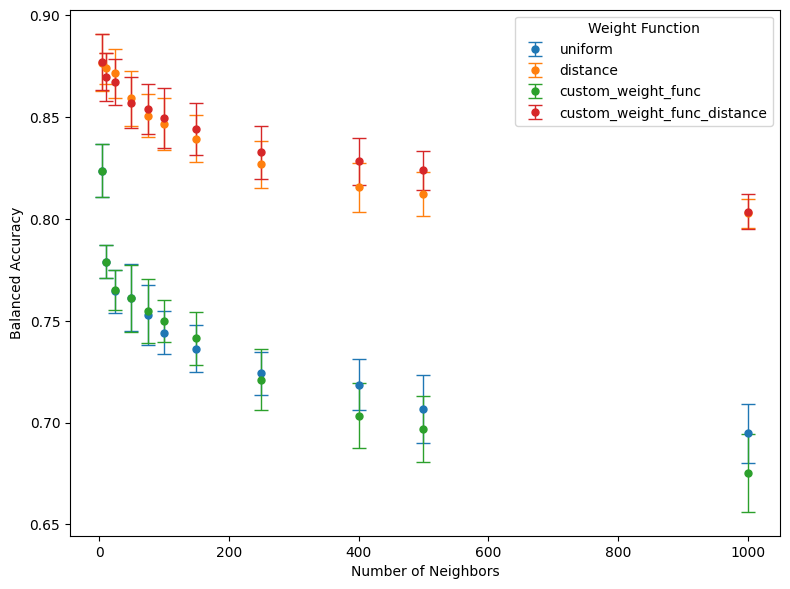

In [76]:
fig, ax = plt.subplots(figsize=(8, 6))

for func in ['uniform', 'distance', 'custom_weight_func', 'custom_weight_func_distance']:
    subset = formatted_results[formatted_results.param_weight_func == func]
    ax.errorbar(subset.param_n_neighbors, subset.mean_test_score,yerr=subset.std_test_score, label=str(func),
                 capsize=5, marker='o', lw=0,elinewidth=1, markersize=5)
ax.set_xlabel("Number of Neighbors")
ax.set_ylabel("Balanced Accuracy")
ax.legend(title="Weight Function")
plt.tight_layout()
#plt.savefig(run.results+f'/knn_cv_results_{int(run.prob_threshold*1000)}.png')
#plt.savefig(run.results+f'/knn_DCA_cv_results_{int(run.prob_threshold*1000)}.png')
plt.savefig(run.results+f'/knn_DCTP_cv_results_{int(run.prob_threshold*1000)}.png')

/Users/dahala/anaconda3/envs/vae_env/lib/python3.8/site-packages/sklearn/neighbors/_classification.py:233: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/Users/dahala/anaconda3/envs/vae_env/lib/python3.8/site-packages/sklearn/neighbors/_classification.py:233: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


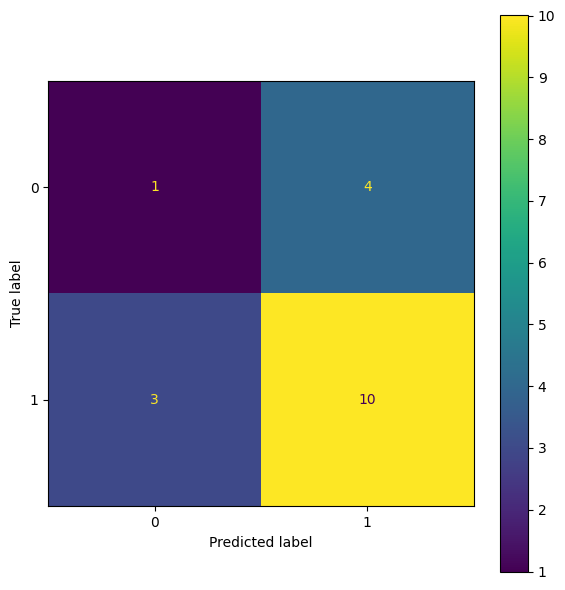

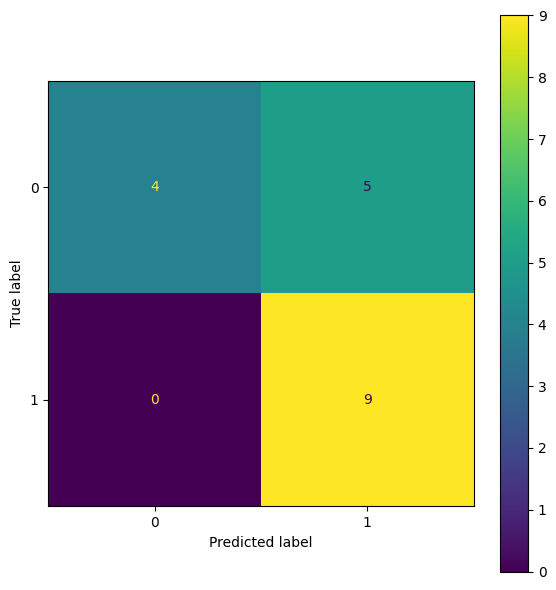

In [77]:
#knn_single(X_test,Y_test,f'knn_single_DCA_{int(run.prob_threshold*1000)}', pretrained=best_knn)
#knn_single(X_test,Y_test_gasp,f'knn_single_DCA_GASP_{int(run.prob_threshold*1000)}', pretrained=best_knn)
knn_single(X_test,Y_test,f'knn_single_DCTP_{int(run.prob_threshold*1000)}', pretrained=best_knn)
knn_single(X_test,Y_test_gasp,f'knn_single_DCTP_GASP_{int(run.prob_threshold*1000)}', pretrained=best_knn)

#### Multi Label

In [44]:
# Example usage
param_grid = {
    'n_neighbors': [5, 10,25, 50, 75, 100,150, 250,400,500,1000],  # Different values of K
    'weight_func': ['uniform', 'distance', custom_weight_func_multi, custom_weight_func_distance_multi],  # Custom and no custom weights
    'label': ['multi']
}

# Assuming X_train and y_train are already defined (from your dataset)
grid_search,best_knn, best_score = gridsearch_knn_with_cv_multilabel(X, y, param_grid)
formatted_results = format_cv_results(grid_search)
# Output results
print(f"Best Parameters: {best_knn.get_params()}")
print(f"Best Balanced Accuracy: {best_score}")

/Users/dahala/anaconda3/envs/vae_env/lib/python3.8/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(io.BytesIO(b))
/Users/

Best Parameters: {'label': 'multi', 'n_neighbors': 5, 'weight_func': <function custom_weight_func_distance_multi at 0x29ce58af0>}
Best Balanced Accuracy: 0.8685891501042633


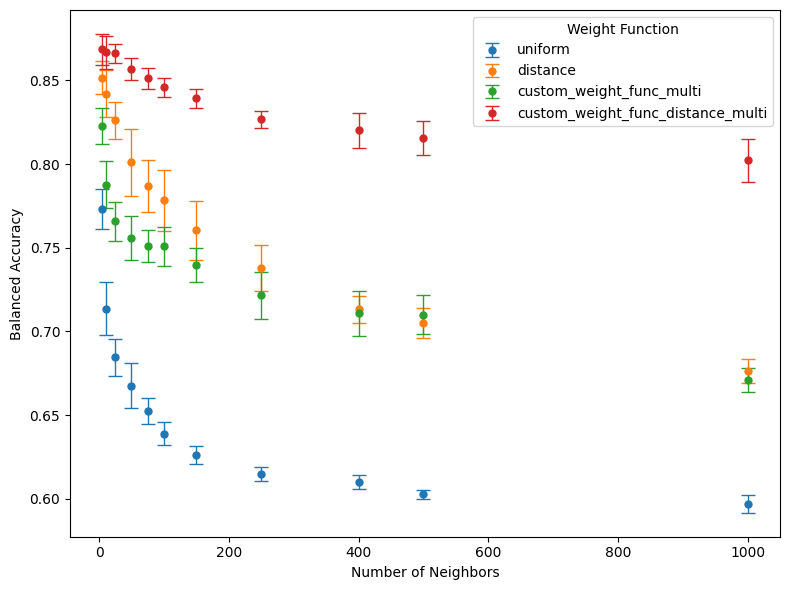

In [45]:
fig, ax = plt.subplots(figsize=(8, 6))

for func in ['uniform', 'distance', 'custom_weight_func_multi', 'custom_weight_func_distance_multi']:
    subset = formatted_results[formatted_results.param_weight_func == func]
    ax.errorbar(subset.param_n_neighbors, subset.mean_test_score,yerr=subset.std_test_score, label=str(func),
                 capsize=5, marker='o', lw=0,elinewidth=1, markersize=5)
ax.set_xlabel("Number of Neighbors")
ax.set_ylabel("Balanced Accuracy")
ax.legend(title="Weight Function")
plt.tight_layout()
plt.savefig(run.results+f'/knn_cv_results_{int(run.prob_threshold*1000)}.png')

/Users/dahala/anaconda3/envs/vae_env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/dahala/anaconda3/envs/vae_env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/dahala/anaconda3/envs/vae_env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result

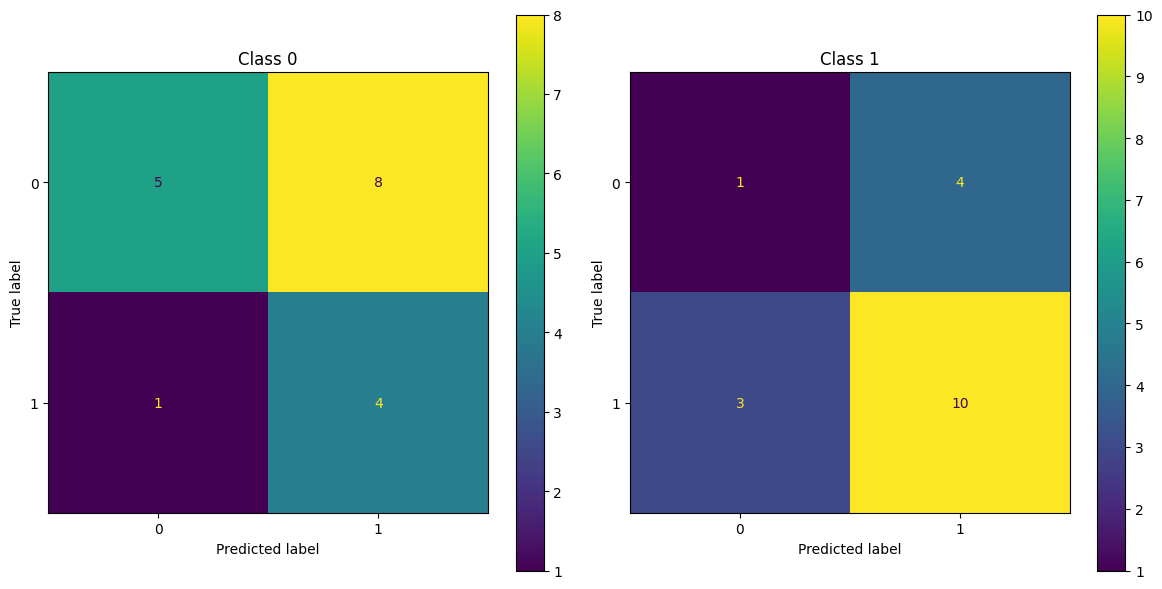

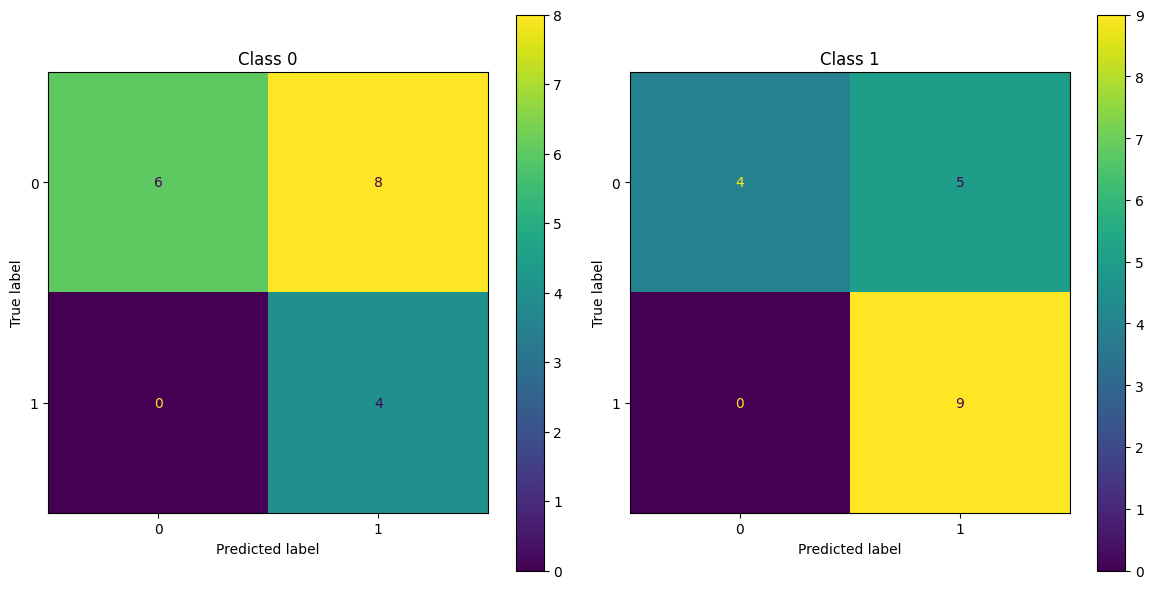

In [46]:
knn_multi(X_test,Y_test,f'knn_multi_DCA_DCTP_{int(run.prob_threshold*1000)}', pretrained=best_knn)
knn_multi(X_test,Y_test_gasp,f'knn_multi_DCA_DCTP_GASP_{int(run.prob_threshold*1000)}', pretrained=best_knn)

### Decoding

In [21]:
vae = latent_space.vae

# Lambda for p(X,Zi)/q(Zi|X) of generated and original, given as sum of equal positions to length of original sequence
marginal = lambda gen, orig: sum([1 if g == o else 0 for g, o in zip(gen, orig)]) / len(orig)

In [22]:
real_labels_DCA = pd.read_csv('../GASP_predictions/pred_blosum62Amb_Dataset1_sequences_7257.tsv',sep='\t',header=1)
real_labels_DCA['bin'] = real_labels_DCA.pred.apply(lambda x: 1 if x >= run.prob_threshold else 0)
real_labels_DCA = real_labels_DCA[real_labels_DCA.enzyme.isin(Dataset1_Dichloroaniline_bin.Official_name.to_list())]
real_labels_DCTP = pd.read_csv('../GASP_predictions/pred_blosum62Amb_Dataset1_sequences_79964.tsv',sep='\t',header=1)
real_labels_DCTP['bin'] = real_labels_DCTP.pred.apply(lambda x: 1 if x >= run.prob_threshold else 0)
real_labels_DCTP = real_labels_DCTP[real_labels_DCTP.enzyme.isin(Dataset1_DCP_bin.Official_name.to_list())]


In [23]:
real_labels_DCA.drop_duplicates(subset='enzyme',inplace=True)
real_labels_DCTP.drop_duplicates(subset='enzyme',inplace=True)


In [24]:
real_labels_DCA_DCTP = pd.merge(real_labels_DCA[['enzyme','bin']],real_labels_DCTP[['enzyme','bin']],on='enzyme',suffixes=('_DCA','_DCTP'))
read_labels_DCA_DCTP = real_labels_DCA_DCTP[real_labels_DCA_DCTP.enzyme.isin(Dataset1_DCA_DCP_bin.Official_name.to_list())]

In [25]:
labels = torch.zeros(18,2)
for i, (val1,val2) in enumerate(zip(read_labels_DCA_DCTP['bin_DCA'],read_labels_DCA_DCTP['bin_DCTP'])):
    labels[i,0] = 1 if val1 == 1 else 0
    labels[i,1] = 1 if val2 == 1 else 0
read_labels_DCA_DCTP['bin'] = labels.tolist()

In [26]:
positive_control = load_from_pkl(os.path.join("../results/EnzymeMiner_PtUGT1/pickles/positive_control.pkl"))

test_size = positive_control.shape[0]
binary_shape = positive_control[0].shape

In [27]:
def decoding_sample(data, c_labels, samples=500):
    """
    Sample for each q(Z|X) for 10 000 times and make average
        1/N * SUM(p(X,Zi)/q(Zi|X))
    """
    probabilities = []
    with torch.no_grad():
        for i, d in enumerate(data):
            # Move 'd' to the correct device
            d = torch.tensor(d).cpu().type(torch.float32)

            if c_labels is not None:
                c = c_labels[i].cpu().unsqueeze(0)
                d = d.reshape(-1).unsqueeze(0)
            else:
                c = None
                d = d.reshape(-1) # Reshape 'd' to 1D
            
            mus, sigma = vae.encoder(d, c)
            if c_labels is not None:
                mus = mus
                sigma = sigma
            else:
                mus = mus.unsqueeze(0)
                sigma = sigma.unsqueeze(0)
            numerical_sequences = vae.decode_samples(mus, sigma, samples, c)
            original_sequence = MSA.binary_to_numbers_coding(d.reshape(binary_shape))
            
            sum_p_X_Zi = 0
            for decoded in numerical_sequences:
                decoded = decoded.to(d.device)  # Ensure 'decoded' is on the correct device
                sum_p_X_Zi += marginal(decoded, original_sequence)
            
            probabilities.append(sum_p_X_Zi / samples)
    return probabilities

In [28]:
Dataset1_unique = Dataset1.drop_duplicates(subset=['Sequence'])
#Dataset1_unique = Dataset1_Dichloroaniline_bin.drop_duplicates(subset=['Sequence'])
#Dataset1_unique = Dataset1_DCP_bin.drop_duplicates(subset=['Sequence'])
#Dataset1_unique = Dataset1_DCA_DCP_bin.drop_duplicates(subset=['Sequence'])

In [29]:
Dataset1_unique.trimmed_afa
Dataset1_unique_msa = {enz:afa for enz,afa in zip(Dataset1_unique['Official_name'],Dataset1_unique['trimmed_afa'])}

In [30]:
Dataset1_unique_msa_numb = MSA.aa_to_number(Dataset1_unique_msa)
Dataset1_unique_msa_numb = np.array(Dataset1_unique_msa_numb, dtype=int)
Dataset1_unique_msa_bin = MSA.number_to_binary(Dataset1_unique_msa_numb)

In [31]:
run.results

'../results/EnzymeMiner_PtUGT1/results'

In [32]:
c = None
#c = torch.tensor(real_labels_DCA['bin'].to_numpy(dtype=float)).unsqueeze(1).type(torch.float32)#Dataset1_Dichloroaniline_labels
#c = torch.tensor(real_labels_DCTP['bin'].to_numpy(dtype=float)).unsqueeze(1).type(torch.float32)#Dataset1_DCP_labels
#c = torch.tensor(read_labels_DCA_DCTP['bin'].to_list())#Dataset1_DCA_DCP_labels
prob_500 = decoding_sample(Dataset1_unique_msa_bin, c, samples=500)
Dataset1_unique_prob = pd.DataFrame(prob_500, index=Dataset1_unique['Official_name'], columns=['prob_500'])

Text(0, 0.5, 'Frequency')

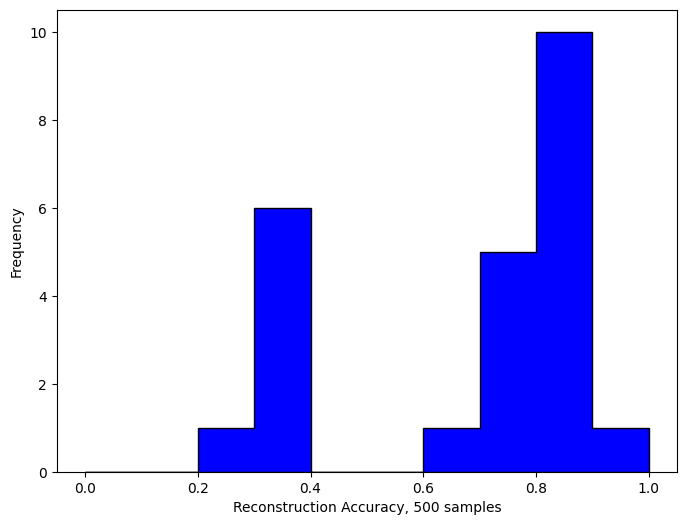

In [33]:
fig, ax = plt.subplots(figsize=(8,6))
ax.hist(prob_500, bins=10, color='blue', edgecolor='black',histtype='stepfilled',range=(0,1))
ax.set_xlabel('Reconstruction Accuracy, 500 samples')
ax.set_ylabel('Frequency')


In [25]:
#Dataset1_unique['Accuracy'] = [Dataset1_unique_prob.prob_500[enz] for enz in Dataset1_unique.Official_name]
Dataset1_Dichloroaniline_bin['Accuracy'] = [Dataset1_unique_prob.prob_500[enz] for enz in Dataset1_Dichloroaniline_bin.Official_name]
#Dataset1_DCP_bin['Accuracy'] = [Dataset1_unique_prob.prob_500[enz] for enz in Dataset1_DCP_bin.Official_name]
#Dataset1_DCA_DCP_bin['Accuracy'] = [Dataset1_unique_prob.prob_500[enz] for enz in Dataset1_DCA_DCP_bin.Official_name]

AttributeError: 'DataFrame' object has no attribute 'Accuracy'

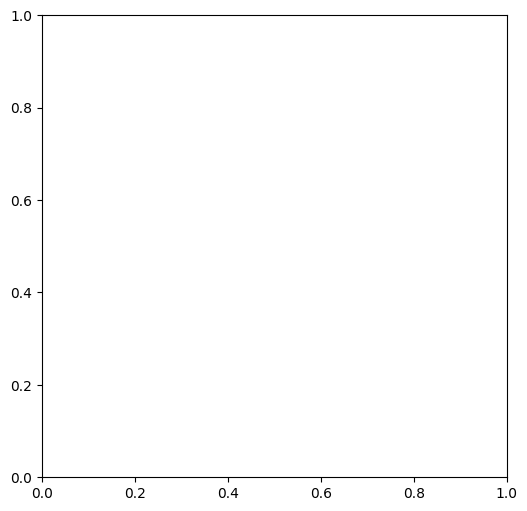

In [42]:
fig_lat, ax = plt.subplots(figsize=(6,6))
# Project
ax.scatter(Dataset1_unique.mu1, Dataset1_unique.mu2, c=Dataset1_unique.Accuracy.to_numpy(dtype=float), alpha=1, s=30,edgecolor='black', zorder=3)
ax.set_xlabel("$Z_1$")
ax.set_ylabel("$Z_2$")



ax.plot(msa_embeddings[:, 0], msa_embeddings[:, 1], '.', alpha=0.1, markersize=3, color='gray')
ax.plot(query_coords[0::2], query_coords[1::2], '.', color='k')

#ax.set_xlim(-3,3)
#ax.set_ylim(-5,2)
ax.set_box_aspect(1)
plt.tight_layout()
fig_lat.savefig(os.path.join(run.results, "latent_space_with_D1_Accuracy.png"))

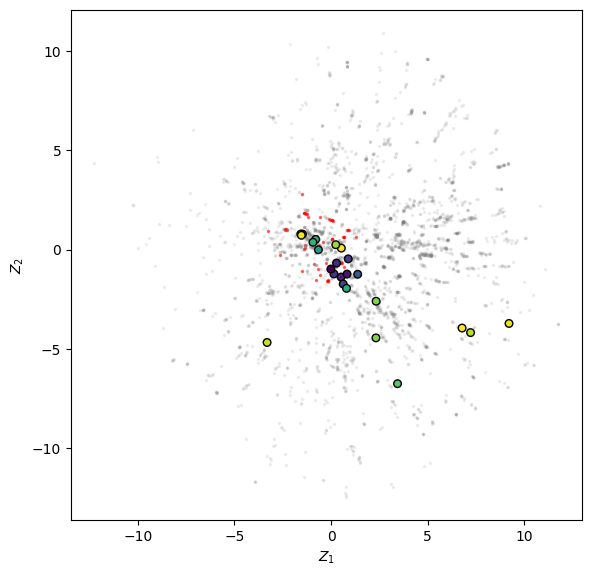

In [26]:
fig_lat, ax = plt.subplots(figsize=(6,6))
# Project
ax.scatter(Dataset1_Dichloroaniline_bin.mu1, Dataset1_Dichloroaniline_bin.mu2, c=Dataset1_Dichloroaniline_bin.Accuracy.to_numpy(dtype=float), alpha=1, s=30,edgecolor='black', zorder=3)
ax.set_xlabel("$Z_1$")
ax.set_ylabel("$Z_2$")


c_color = 'red'
conditional = True
if conditional:
    for i,label in enumerate(msa_key_label_order.values()):
        if label[0] == 1:
        #if label[0] == 0:
            ax.plot(msa_embeddings[i, 0], msa_embeddings[i, 1], '.', alpha=0.5, markersize=3, color=c_color)
        else:
            ax.plot(msa_embeddings[i, 0], msa_embeddings[i, 1], '.', alpha=0.1, markersize=3, color='gray')
    ax.plot(query_coords[0::2], query_coords[1::2], '.', color='k')
else:
    ax.plot(msa_embeddings[:, 0], msa_embeddings[:, 1], '.', alpha=0.1, markersize=3, color='gray')
    ax.plot(query_coords[0::2], query_coords[1::2], '.', color='black')
#ax.set_xlim(-3,3)
#ax.set_ylim(-5,2)
ax.set_box_aspect(1)
plt.tight_layout()
fig_lat.savefig(os.path.join(run.results, "latent_space_with_D1_Accuracy.png"))

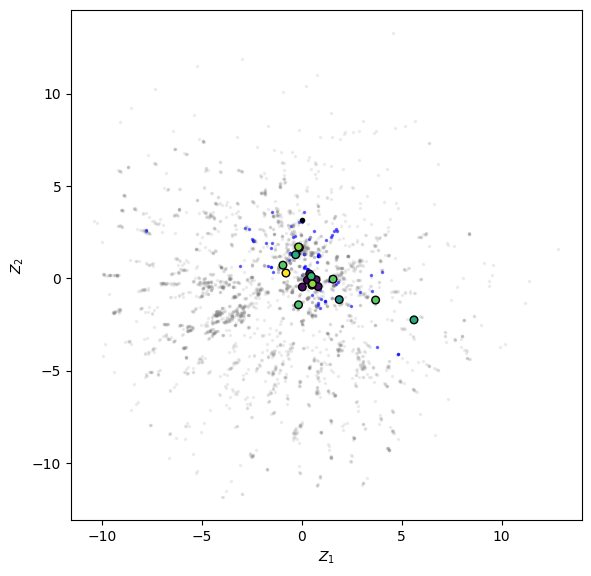

In [35]:
fig_lat, ax = plt.subplots(figsize=(6,6))
# Project
ax.scatter(Dataset1_DCP_bin.mu1, Dataset1_DCP_bin.mu2, c=Dataset1_DCP_bin.Accuracy.to_numpy(dtype=float), alpha=1, s=30,edgecolor='black', zorder=3)
ax.set_xlabel("$Z_1$")
ax.set_ylabel("$Z_2$")


c_color = 'blue'
conditional = True
if conditional:
    for i,label in enumerate(msa_key_label_order.values()):
        if label[0] == 1:
        #if label[0] == 0:
            ax.plot(msa_embeddings[i, 0], msa_embeddings[i, 1], '.', alpha=0.5, markersize=3, color=c_color)
        else:
            ax.plot(msa_embeddings[i, 0], msa_embeddings[i, 1], '.', alpha=0.1, markersize=3, color='gray')
    ax.plot(query_coords[0::2], query_coords[1::2], '.', color='k')
else:
    ax.plot(msa_embeddings[:, 0], msa_embeddings[:, 1], '.', alpha=0.1, markersize=3, color='gray')
    ax.plot(query_coords[0::2], query_coords[1::2], '.', color='black')
#ax.set_xlim(-3,3)
#ax.set_ylim(-5,2)
ax.set_box_aspect(1)
plt.tight_layout()
fig_lat.savefig(os.path.join(run.results, "latent_space_with_D1_Accuracy.png"))

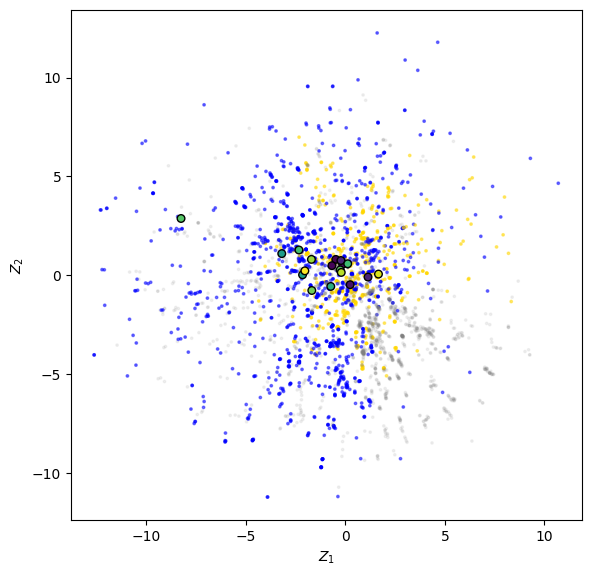

In [44]:
fig_lat, ax = plt.subplots(figsize=(6,6))

color_msa = []
alpha_msa = []
for i,label in enumerate(msa_key_label_order.values()):
    color_msa.append(color_dict[str(label.tolist())])
    alpha_msa.append(alpha_dict[str(label.tolist())])
ax.scatter(msa_embeddings[:, 0], msa_embeddings[:, 1], c=color_msa, alpha=alpha_msa, s=3, zorder=3)

ax.scatter(Dataset1_DCA_DCP_bin.mu1, Dataset1_DCA_DCP_bin.mu2, c=Dataset1_DCA_DCP_bin.Accuracy.to_numpy(dtype=float), alpha=1, s=30,edgecolor='black', zorder=3)


ax.set_xlabel("$Z_1$")
ax.set_ylabel("$Z_2$")


ax.set_box_aspect(1)
plt.tight_layout()
fig_lat.savefig(os.path.join(run.results, "latent_space_with_D1_Accuracy.png"))